In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr
from salishsea_tools import viz_tools
import os

In [2]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return 1 - (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def wolfram_perp2( obs, mod):
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * obs
    
    nonsyst = np.sqrt(((mod - predictions)**2).mean())
    systematic = np.sqrt(((predictions - obs)**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5)  ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.01)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.01)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

def get_combined(years, years_og, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False,gridN='None',straitn='_'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/gridV/ObsModel_202111_CIOOS_gridV_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_gridU_{year}0101_{year}1231.csv')
    for year in years_og:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}0331.csv'
        file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0401_{year}1031.csv'
        file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}1001_{year}1231.csv'
        file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}0430.csv'

        if os.path.exists(file_path1):
            pieces1.append(file_path1)

        if os.path.exists(file_path2):
            pieces1.append(file_path2)

        if os.path.exists(file_path3):
            pieces1.append(file_path3)

        if os.path.exists(file_path4):
            pieces1.append(file_path4)

        if os.path.exists(file_path5):
            pieces1.append(file_path5)

    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        
        if straitn == 'all':
            for ii in ['_','_jdf_']:
                file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}1231.csv'
                file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}0331.csv'
                file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0401_{year}1031.csv'
                file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}1001_{year}1231.csv'
                file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}0430.csv'

                if os.path.exists(file_path1):
                    pieces1.append(file_path1)

                if os.path.exists(file_path2):
                    pieces1.append(file_path2)

                if os.path.exists(file_path3):
                    pieces1.append(file_path3)

                if os.path.exists(file_path4):
                    pieces1.append(file_path4)

                if os.path.exists(file_path5):
                    pieces1.append(file_path5)
            
        else:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}1231.csv'
            file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}0331.csv'
            file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0401_{year}1031.csv'
            file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}1001_{year}1231.csv'
            file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}0430.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)

            if os.path.exists(file_path2):
                pieces1.append(file_path2)

            if os.path.exists(file_path3):
                pieces1.append(file_path3)

            if os.path.exists(file_path4):
                pieces1.append(file_path4)

            if os.path.exists(file_path5):
                pieces1.append(file_path5)
            

    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    # data_filter = temp1[temp1[modn].notna()]
    # print(data_filter)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

In [5]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_sog,d_uvel_sog = get_combined([2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_uvel_sog.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.63,0.68,0.00215,0.104,0.0689,0.731


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.63,0.68,0.00215,0.104,0.0689,0.731


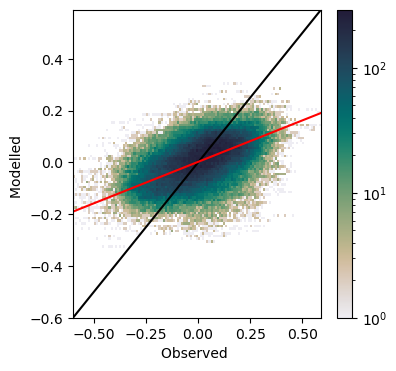

In [6]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( data_uvel_sog['current_velocity_east'],data_uvel_sog['mod_vozocrtx'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed ')
ax.set_ylabel(f'Modelled ')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_sog,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['mod_vozocrtx'],data['LCEWEL01'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_uvel_sog.style.format(myformat).apply(highlight_max_min))


### V-velocity

In [7]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_sog,d_vvel_sog = get_combined([2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel_sog.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,116054,-0.0163,0.0965,0.0951,0.865,-0.293,-0.00827,0.0396,0.104,-0.496


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,161492,-0.00268,0.132,0.132,0.63,0.68,0.00215,0.104,0.0689,0.731


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,116054,-0.0163,0.0965,0.0951,0.865,-0.293,-0.00827,0.0396,0.104,-0.496


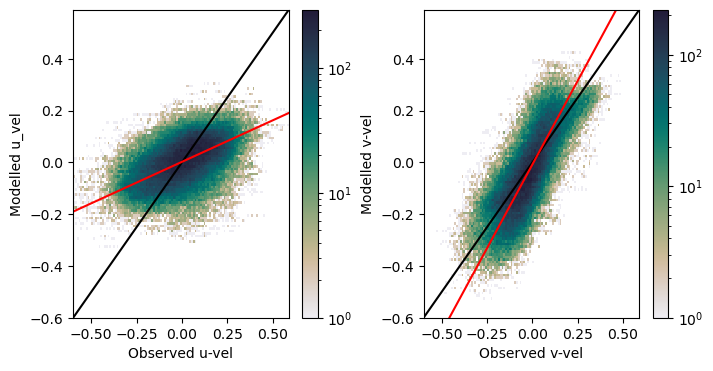

In [8]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_sog['current_velocity_east'],data_uvel_sog['mod_vozocrtx'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_sog,'current_velocity_east','mod_vozocrtx')
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(data_uvel['LCEWEL01'],data_uvel['mod_vozocrtx'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
counts, xedges, yedges, color = ax2.hist2d( data_vvel_sog['current_velocity_north'],data_vvel_sog['mod_vomecrty'],
                                           bins=np.arange(vmin, vmax, dbin),norm=LogNorm(), cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v-vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_sog,'current_velocity_north',modn)
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['LCNSEL01'],data['mod_vomecrty'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_uvel_sog.style.format(myformat).apply(highlight_max_min))
d_vvel_sog.style.format(myformat).apply(highlight_max_min)

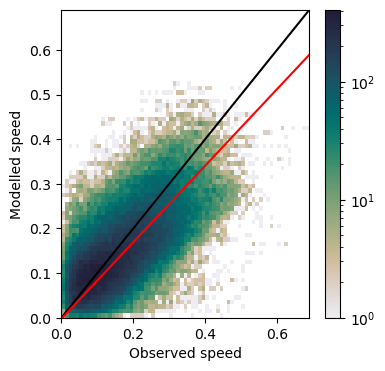

In [9]:
obs_speed = np.sqrt(data_uvel_sog['current_velocity_east']**2+data_vvel_sog['current_velocity_north']**2)
mod_speed = np.sqrt(data_uvel_sog['mod_vozocrtx']**2+data_vvel_sog['mod_vomecrty']**2)
vmin = 0
vmax = 0.7

fig,ax = plt.subplots(1,1,figsize=(4,4))

counts, xedges, yedges, color = ax.hist2d( obs_speed,mod_speed,
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed speed')
ax.set_ylabel(f'Modelled speed')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp2(obs_speed,mod_speed)
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(obs_speed,mod_speed,1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')

In [10]:
data_uvel_sog['mod_east_vel'] = data_uvel_sog['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_sog['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_sog['mod_north_vel'] = data_uvel_sog['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_sog['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel = get_stats(filter_bad_data(data_uvel_sog),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel = get_stats(filter_bad_data(data_vvel_sog),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_vvel.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,117679,0.0113,0.0887,0.088,0.881,0.257,0.0153,0.0415,0.071,0.416


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,116054,-0.00784,0.0845,0.0841,0.871,0.00822,-0.00806,0.0079,0.0838,0.0132


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,117679,0.0113,0.0887,0.088,0.881,0.257,0.0153,0.0415,0.071,0.416


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,116054,-0.00784,0.0845,0.0841,0.871,0.00822,-0.00806,0.0079,0.0838,0.0132


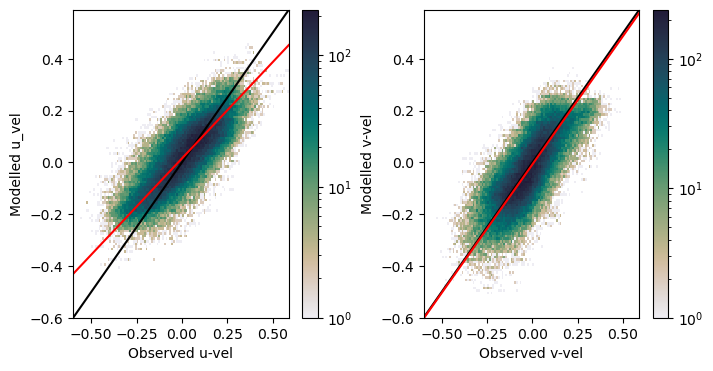

In [11]:
vmax = 0.6
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_sog['current_velocity_east'],data_uvel_sog['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_sog,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(data_uvel['i_vel'],data_uvel['mod_vozocrtx'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
counts, xedges, yedges, color = ax2.hist2d( data_vvel_sog['current_velocity_north'],data_vvel_sog['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin),norm=LogNorm(), cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v-vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_sog,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['LCNSEL01'],data['mod_vomecrty'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_uvel.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)


Text(0.5, 0.98, 'V-velocity')

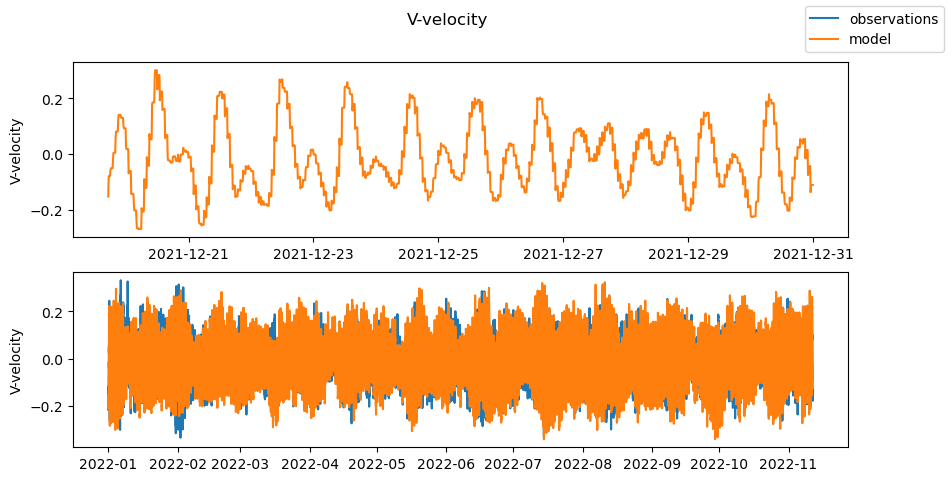

In [12]:
data_vvel_sog['dtime'] = pd.to_datetime(data_vvel_sog['dtUTC'])
data_2021 = data_vvel_sog[(data_vvel_sog['dtime'].dt.year == 2021) ]
data_2022 = data_vvel_sog[(data_vvel_sog['dtime'].dt.year == 2022) ]

fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))
ax2.plot(data_2022['dtime'],data_2022['current_velocity_north'],label='observations')
ax2.plot(data_2022['dtime'],data_2022['mod_north_vel'],label='model')
ax.plot(data_2021['dtime'],data_2021['current_velocity_north'])
ax.plot(data_2021['dtime'],data_2021['mod_north_vel'])
ax.set_ylabel('V-velocity')
ax2.set_ylabel('V-velocity')
fig.legend()
fig.suptitle('V-velocity')

Text(0.5, 0.98, 'U-velocity')

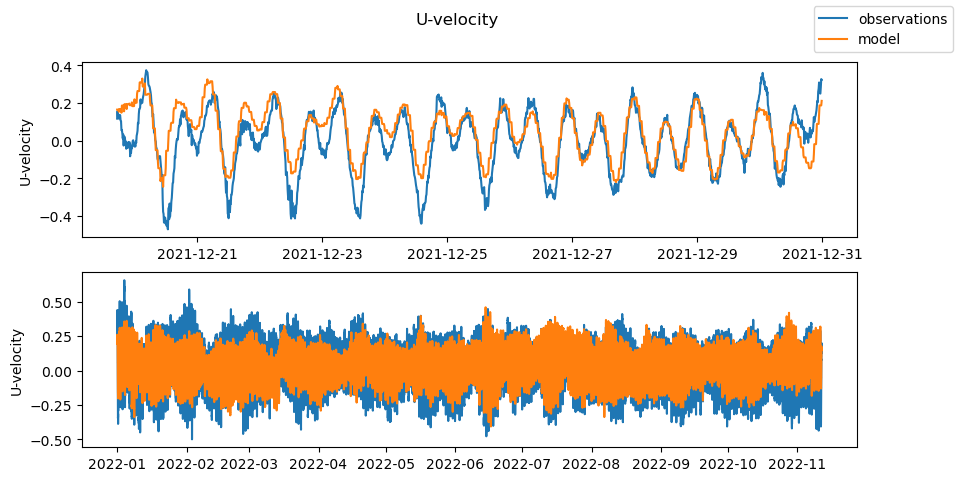

In [13]:
data_uvel_sog['dtime'] = pd.to_datetime(data_uvel_sog['dtUTC'])
data_uvel_2021 = data_uvel_sog[(data_uvel_sog['dtime'].dt.year == 2021) ]
data_uvel_2022 = data_uvel_sog[(data_uvel_sog['dtime'].dt.year == 2022) ]

fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))
ax2.plot(data_uvel_2022['dtime'],data_uvel_2022['current_velocity_east'],label='observations')
ax2.plot(data_uvel_2022['dtime'],data_uvel_2022['mod_east_vel'],label='model')
ax.plot(data_uvel_2021['dtime'],data_uvel_2021['current_velocity_east'])
ax.plot(data_uvel_2021['dtime'],data_uvel_2021['mod_east_vel'])

ax.set_ylabel('U-velocity')
ax2.set_ylabel('U-velocity')
fig.legend()
fig.suptitle('U-velocity')

Text(0.5, 0.98, 'Speed')

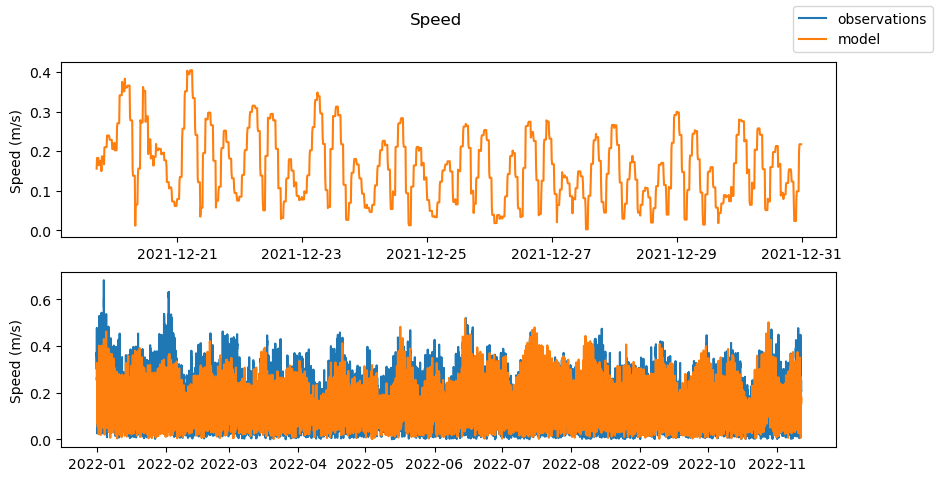

In [14]:
data_vvel_sog['dtime'] = pd.to_datetime(data_vvel_sog['dtUTC'])
data_vvel_sog['obs_speed'] = obs_speed
data_vvel_sog['mod_speed'] = mod_speed
data_2021 = data_vvel_sog[(data_vvel_sog['dtime'].dt.year == 2021) ]
data_2022 = data_vvel_sog[(data_vvel_sog['dtime'].dt.year == 2022) ]

fig,[ax,ax2] = plt.subplots(2,1,figsize=(10,5))
ax2.plot(data_2022['dtime'],data_2022['obs_speed'],label='observations')
ax2.plot(data_2022['dtime'],data_2022['mod_speed'],label='model')
ax.plot(data_2021['dtime'],data_2021['obs_speed'])
ax.plot(data_2021['dtime'],data_2021['mod_speed'])
ax.set_ylabel('Speed (m/s)')
ax2.set_ylabel('Speed (m/s)')
fig.legend()
fig.suptitle('Speed')

Model slightly underestimating 

## Look @ ONC data

In [15]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 1.5
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel,d_uvel = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_uvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,345764,0.0321,0.343,0.341,0.687,-0.691,-0.112,0.201,0.443,-0.71


Text(0.5, 1.0, 'u-vel')

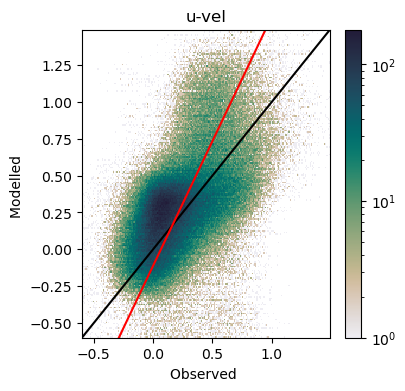

In [16]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( data_uvel['current_velocity_east'],data_uvel['mod_vozocrtx'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed ')
ax.set_ylabel(f'Modelled ')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['mod_vozocrtx'],data['LCEWEL01'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('u-vel')

In [17]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel,d_vvel = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,-0.046,0.23,0.225,0.761,0.369,0.00181,0.115,0.172,0.444


In [18]:
data_uvel['mod_east_vel'] = data_uvel['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel['mod_north_vel'] = data_uvel['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel = get_stats(filter_bad_data(data_uvel),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

data_vvel_d = data_vvel[data_vvel['mod_north_vel'].notna()]
d_vvel = get_stats(filter_bad_data(data_vvel_d),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_vvel.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


Text(0.5, 1.0, 'Rotated v-vel')

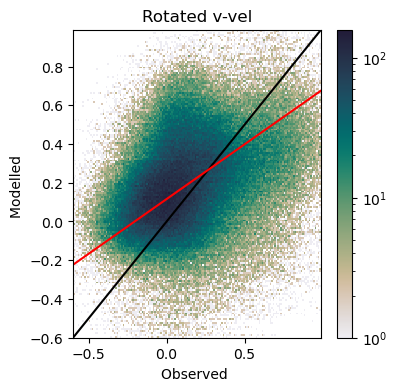

In [19]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( data_vvel['current_velocity_north'],data_vvel['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed ')
ax.set_ylabel(f'Modelled ')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['mod_vozocrtx'],data['LCEWEL01'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Rotated v-vel')

Text(0.5, 1.0, 'Rotated u-vel')

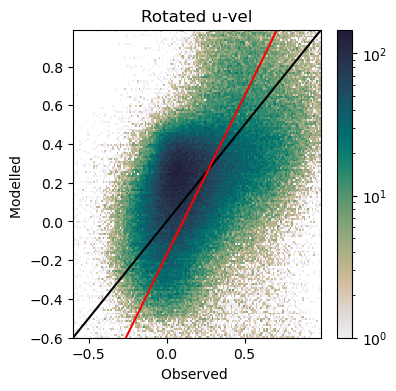

In [20]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( data_uvel['current_velocity_east'],data_uvel['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel(f'Observed ')
ax.set_ylabel(f'Modelled ')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1

# slope,intercept = np.polyfit(data['mod_vozocrtx'],data['LCEWEL01'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Rotated u-vel')

Text(0.5, 1.0, 'Speed')

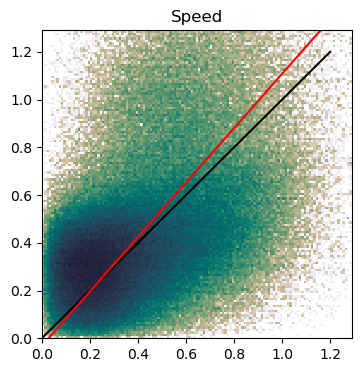

In [21]:
obs_speed = np.sqrt(data_uvel['current_velocity_east']**2 + data_vvel['current_velocity_north']**2)
mod_speed = np.sqrt(data_uvel['mod_east_vel']**2+data_vvel['mod_north_vel']**2)
data_uvel['obs_speed'] = obs_speed
data_uvel['mod_speed'] = mod_speed

vmin = 0
vmax = 1.3

fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( obs_speed,mod_speed,
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.plot(np.arange(vmin,vmax,0.1),np.arange(vmin,vmax,0.1),'k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,'obs_speed','mod_speed')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Speed')

#### Look @ 2012 unmodified depth to compare, then rotate and compare again

In [22]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_OG,d_uvel_OG = get_combined([]
                                          , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
                                          , []#
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []
                                          , idepth, jdepth, 'alldepths')

display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_uvel_OG.style.format(myformat).apply(highlight_max_min))

# plt.scatter(data_uvel_2012['mod_vozocrtx'],data_uvel_OG['mod_vozocrtx'],s=1)
# plt.plot(np.arange(-1,1,0.1),np.arange(-1,1,0.1),'k')

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,361175,0.00784,0.281,0.281,0.703,0.0847,0.0254,0.0254,0.269,0.084


In [23]:
data_uvel_OG['mod_east_vel'] = data_uvel_OG['mod_vozocrtx']*np.cos(np.deg2rad(29))
data_uvel_OG['mod_north_vel'] = data_uvel_OG['mod_vozocrtx']*np.sin(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_OG = get_stats(filter_bad_data(data_uvel_OG),'u-vel OG' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_OG = get_stats(filter_bad_data(data_uvel_OG),'v-vel OG' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_OG.style.format(myformat).apply(highlight_max_min))
display(d_vvel_OG.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel OG,361175,-0.0192,0.268,0.267,0.696,0.298,0.0426,0.0872,0.224,0.299


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel OG,361175,-0.0289,0.23,0.228,0.657,0.673,0.0609,0.194,0.105,0.782


In [24]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


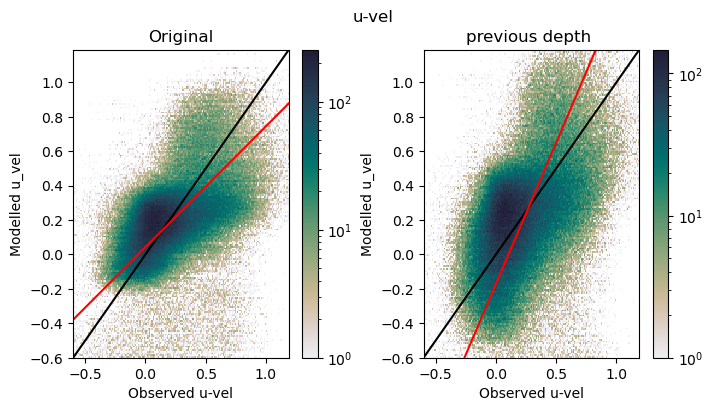

In [25]:
vmax = 1.2
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_OG['current_velocity_east'],data_uvel_OG['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_OG,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Original')

counts, xedges, yedges, color = ax2.hist2d( data_uvel['current_velocity_east'],data_uvel['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed u-vel')
ax2.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('previous depth ')
fig.suptitle('u-vel')
fig.subplots_adjust(wspace=0.3)

display(d_uvel.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel OG,361175,-0.0289,0.23,0.228,0.657,0.673,0.0609,0.194,0.105,0.782


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


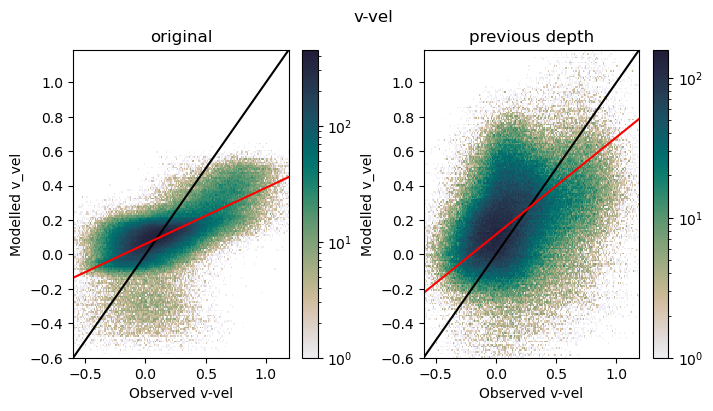

In [26]:
vmax = 1.2
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_OG['current_velocity_north'],data_uvel_OG['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed v-vel')
ax.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_OG,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('original')

counts, xedges, yedges, color = ax2.hist2d( data_vvel['current_velocity_north'],data_vvel['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('previous depth')
fig.suptitle('v-vel')
fig.subplots_adjust(wspace=0.3)

display(d_vvel_OG.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)

Use only the v-velocity from above timestep

In [27]:
data_uvel_comb = data_uvel_OG
data_vvel_comb = data_vvel

data_uvel_comb['mod_east_vel'] = data_uvel_OG['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_comb['mod_north_vel'] = data_uvel_OG['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_comb = get_stats(filter_bad_data(data_uvel_comb),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_comb = get_stats(filter_bad_data(data_vvel_comb),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_OG.style.format(myformat).apply(highlight_max_min))
display(d_vvel_OG.style.format(myformat).apply(highlight_max_min))
display(d_uvel.style.format(myformat).apply(highlight_max_min))
display(d_vvel.style.format(myformat).apply(highlight_max_min))
display(d_uvel_comb.style.format(myformat).apply(highlight_max_min))
display(d_vvel_comb.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel OG,361175,-0.0192,0.268,0.267,0.696,0.298,0.0426,0.0872,0.224,0.299


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel OG,361175,-0.0289,0.23,0.228,0.657,0.673,0.0609,0.194,0.105,0.782


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0582,0.285,0.279,0.675,0.235,-0.00948,0.0891,0.244,0.229


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0484,0.257,0.253,0.722,0.289,0.0858,0.0953,0.212,0.312


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel OG,361175,-0.0192,0.268,0.267,0.696,0.298,0.0426,0.0872,0.224,0.299


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


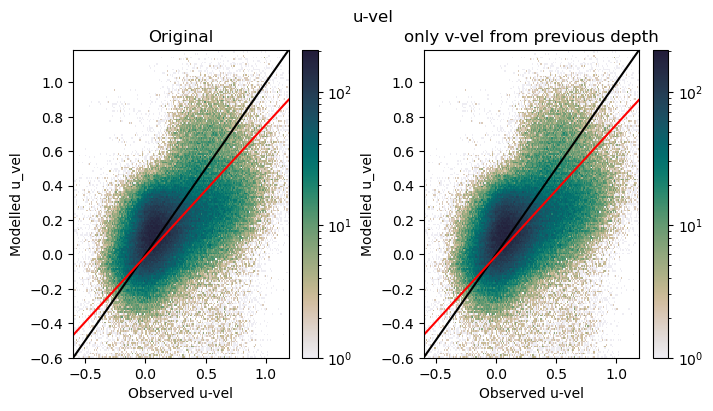

In [28]:
vmax = 1.2
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_OG['current_velocity_east'],data_uvel_OG['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_OG,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Original')

counts, xedges, yedges, color = ax2.hist2d( data_uvel_comb['current_velocity_east'],data_uvel_comb['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed u-vel')
ax2.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_comb,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('only v-vel from previous depth')
fig.suptitle('u-vel')
fig.subplots_adjust(wspace=0.3)

display(d_uvel_OG.style.format(myformat).apply(highlight_max_min))
d_uvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel OG,361175,-0.0289,0.23,0.228,0.657,0.673,0.0609,0.194,0.105,0.782


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


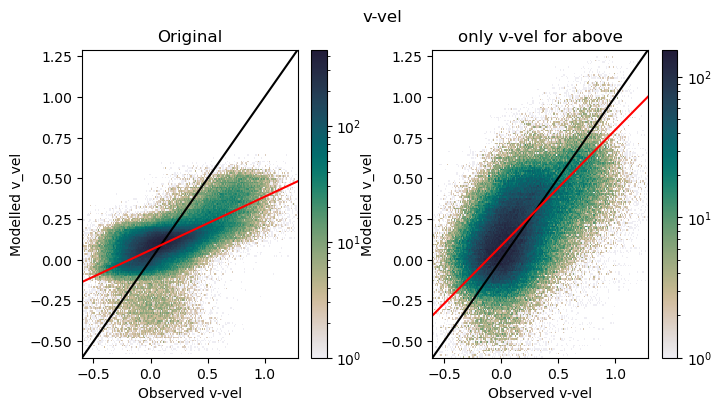

In [29]:
vmax = 1.3
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_OG['current_velocity_north'],data_uvel_OG['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed v-vel')
ax.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_OG,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Original')

counts, xedges, yedges, color = ax2.hist2d( data_vvel_comb['current_velocity_north'],data_vvel_comb['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_comb,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('only v-vel for above')
fig.suptitle('v-vel')
fig.subplots_adjust(wspace=0.3)

display(d_vvel_OG.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,341841,-0.0386,0.345,0.342,0.67,-0.642,-0.172,0.188,0.441,-0.602


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,341841,0.0596,0.308,0.303,0.581,0.435,0.116,0.137,0.236,0.325


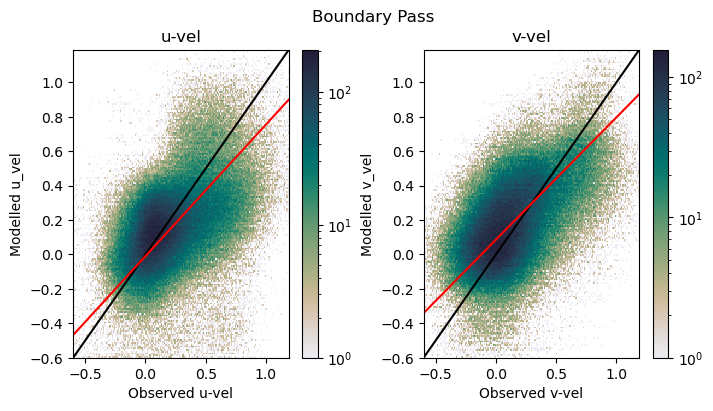

In [30]:
vmax = 1.2
vmin = -0.6

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_comb['current_velocity_east'],data_uvel_comb['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_comb,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('u-vel')
fig.suptitle('Boundary Pass')
fig.subplots_adjust(wspace=0.3)

counts, xedges, yedges, color = ax2.hist2d( data_vvel_comb['current_velocity_north'],data_vvel_comb['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_comb,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('v-vel')
fig.subplots_adjust(wspace=0.3)

display(d_uvel.style.format(myformat).apply(highlight_max_min))
d_vvel.style.format(myformat).apply(highlight_max_min)

Text(0.5, 1.0, 'Speed')

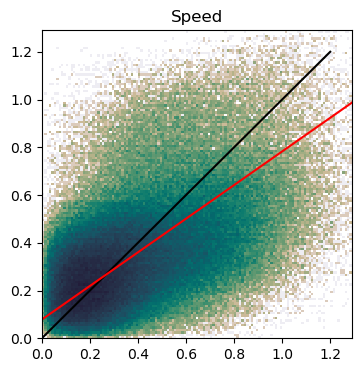

In [31]:
obs_speed_comb = np.sqrt(data_uvel_comb['current_velocity_east']**2+data_vvel_comb['current_velocity_north']**2)
mod_speed_comb = np.sqrt(data_uvel_comb['mod_east_vel']**2+data_vvel_comb['mod_north_vel']**2)

data_uvel_comb['obs_speed'] = obs_speed_comb
data_uvel_comb['mod_speed'] = mod_speed_comb

vmin = 0
vmax = 1.3

fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( obs_speed_comb,mod_speed_comb,
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.plot(np.arange(vmin,vmax,0.1),np.arange(vmin,vmax,0.1),'k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_comb,'obs_speed','mod_speed')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Speed')

### ONC - JdF

Don't have to modify anything (v-vel exists)

In [32]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 1.5
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_jdf,d_uvel_jdf = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn,straitn='_jdf_')

display(d_uvel_jdf.style.format(myformat).apply(highlight_max_min))

field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_jdf,d_vvel_jdf = get_combined([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn,straitn='_jdf_')

d_vvel_jdf.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,245157,0.0115,0.212,0.211,0.866,0.447,0.028,0.167,0.111,0.647


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,245157,-0.00554,0.226,0.226,0.697,0.656,0.0224,0.194,0.0977,0.796


In [33]:
data_uvel_jdf['mod_east_vel'] = data_uvel_jdf['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_jdf['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_jdf['mod_north_vel'] = data_uvel_jdf['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_jdf['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_jdf = get_stats(filter_bad_data(data_uvel_jdf),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

data_vvel_jdf = data_vvel_jdf[data_vvel_jdf['mod_north_vel'].notna()]
d_vvel_jdf = get_stats(filter_bad_data(data_vvel_jdf),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_jdf.style.format(myformat).apply(highlight_max_min))
display(d_vvel_jdf.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,245157,-0.0125,0.232,0.232,0.824,0.523,0.00681,0.195,0.107,0.721


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,245157,0.0133,0.197,0.197,0.807,0.509,0.035,0.151,0.107,0.68


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,245157,0.0133,0.197,0.197,0.807,0.509,0.035,0.151,0.107,0.68


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,245157,-0.0125,0.232,0.232,0.824,0.523,0.00681,0.195,0.107,0.721


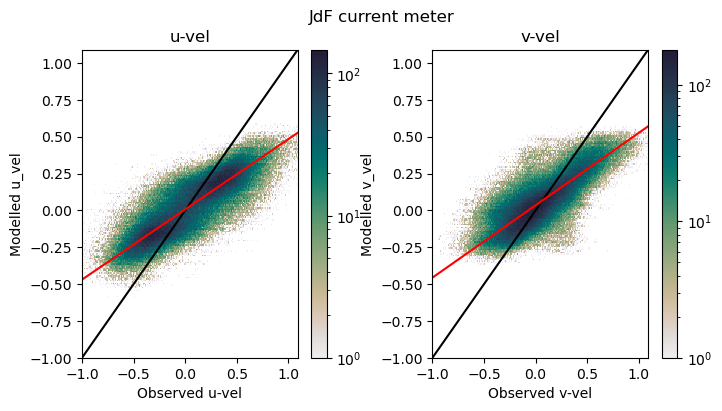

In [34]:
vmax = 1.1
vmin = -1

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_jdf['current_velocity_east'],data_uvel_jdf['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_jdf,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(data_uvel['i_vel'],data_uvel['mod_vozocrtx'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('u-vel')

counts, xedges, yedges, color = ax2.hist2d( data_vvel_jdf['current_velocity_north'],data_vvel_jdf['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_jdf,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('v-vel')
fig.suptitle('JdF current meter')
fig.subplots_adjust(wspace=0.3)

display(d_vvel_jdf.style.format(myformat).apply(highlight_max_min))
d_uvel_jdf.style.format(myformat).apply(highlight_max_min)

Text(0.5, 1.0, 'Speed, JdF current meter')

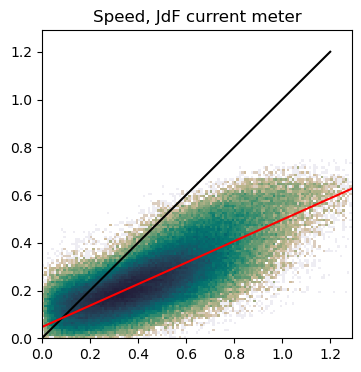

In [35]:
obs_speed_jdf = np.sqrt(data_uvel_jdf['current_velocity_east']**2 + data_vvel_jdf['current_velocity_north']**2)
mod_speed_jdf = np.sqrt(data_uvel_jdf['mod_east_vel']**2 + data_vvel_jdf['mod_north_vel']**2)

data_uvel_jdf['obs_speed'] = obs_speed_jdf
data_uvel_jdf['mod_speed'] = mod_speed_jdf

vmin = 0
vmax = 1.3

fig,ax = plt.subplots(1,1,figsize=(4,4))
counts, xedges, yedges, color = ax.hist2d( obs_speed_jdf,mod_speed_jdf,
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.plot(np.arange(vmin,vmax,0.1),np.arange(vmin,vmax,0.1),'k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_jdf,'obs_speed','mod_speed')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('Speed, JdF current meter')

Plot all currents together on one

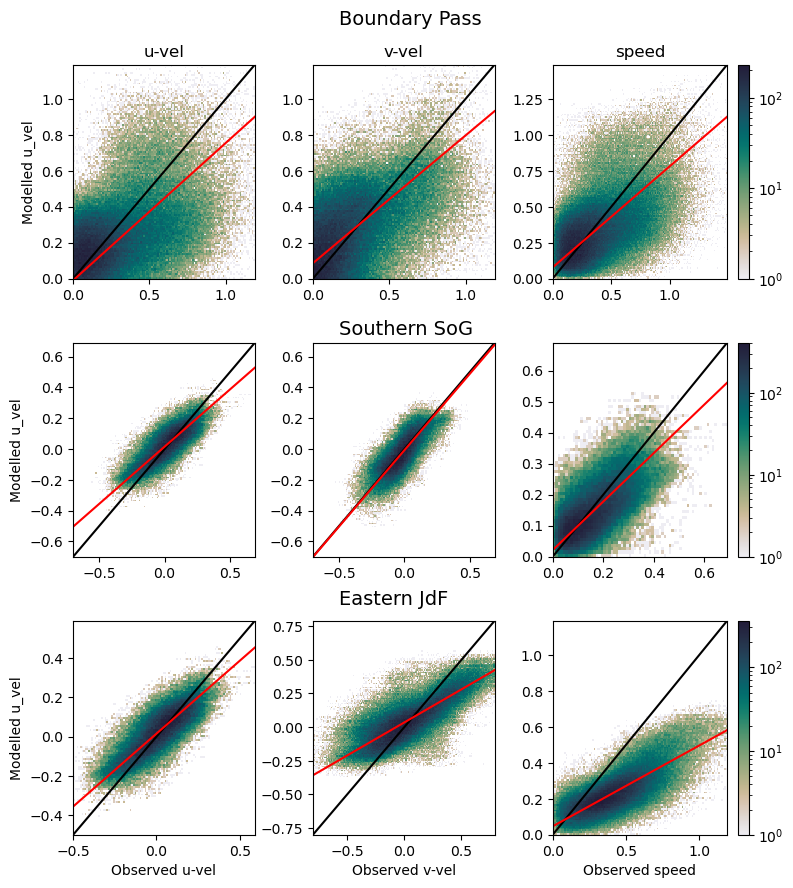

In [36]:
fig,[[ax4,ax5,ax6],[ax7,ax8,ax9],[ax,ax2,ax3]] = plt.subplots(3,3,figsize=(9,10),gridspec_kw={'width_ratios':[1,1,1.2]})

counts, xedges, yedges, color = ax4.hist2d( data_uvel_comb['current_velocity_east'],data_uvel_comb['mod_east_vel'],
                                           bins=np.arange(vmin, 1.2, dbin), norm=LogNorm(),cmap=cmap);

ax4.set_ylabel(f'Modelled u_vel')
ax4.plot(np.arange(vmin,1.2,0.01),np.arange(vmin,1.2,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_comb,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, 1.2, 0.01)*b1
ax4.plot(np.arange(vmin,1.2,0.01),line,'r')
ax4.set_title('u-vel')

counts, xedges, yedges, color = ax5.hist2d( data_vvel_comb['current_velocity_north'],data_vvel_comb['mod_north_vel'],
                                           bins=np.arange(vmin, 1.2, dbin), norm=LogNorm(),cmap=cmap);

ax5.plot(np.arange(vmin,1.2,0.01),np.arange(vmin,1.2,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_comb,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, 1.2, 0.01)*b1
ax5.plot(np.arange(vmin,1.2,0.01),line,'r')
ax5.set_title('v-vel')
fig.subplots_adjust(wspace=0.3)

counts, xedges, yedges, color = ax6.hist2d( data_uvel_comb['obs_speed'],data_uvel_comb['mod_speed'],
                                           bins=np.arange(0, 1.5, dbin), norm=LogNorm(),cmap=cmap);

fig.colorbar(color, ax=ax6)
ax6.plot(np.arange(0,1.5,0.01),np.arange(0,1.5,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_comb,'obs_speed','mod_speed')
line = a1+np.arange(0, 1.5, 0.01)*b1
ax6.plot(np.arange(0,1.5,0.01),line,'r')
ax6.set_title('speed');

vmin = -0.7
vmax = 0.7

counts, xedges, yedges, color = ax7.hist2d( data_uvel_sog['current_velocity_east'],data_uvel_sog['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);

ax7.set_ylabel(f'Modelled u_vel')
ax7.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_sog,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax7.plot(np.arange(vmin,vmax,0.01),line,'r')

counts, xedges, yedges, color = ax8.hist2d( data_vvel_sog['current_velocity_north'],data_vvel_sog['mod_north_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);

ax8.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_sog,'current_velocity_north','mod_north_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax8.plot(np.arange(vmin,vmax,0.01),line,'r')
fig.subplots_adjust(wspace=0.3)
vmin=0
counts, xedges, yedges, color = ax9.hist2d( data_vvel_sog['obs_speed'],data_vvel_sog['mod_speed'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);

fig.colorbar(color, ax=ax9)
ax9.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_sog,'obs_speed','mod_speed')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax9.plot(np.arange(vmin,vmax,0.01),line,'r')

vmin = -0.5
vmax = 0.6

counts, xedges, yedges, color = ax.hist2d( data_uvel_sog['current_velocity_east'],data_uvel_sog['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_sog,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax.plot(np.arange(vmin,vmax,0.01),line,'r')

counts, xedges, yedges, color = ax2.hist2d( data_vvel_jdf['current_velocity_north'],data_vvel_jdf['mod_north_vel'],
                                           bins=np.arange(-0.8, 0.8, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.plot(np.arange(-0.8,0.8,0.01),np.arange(-0.8,0.8,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_jdf,'current_velocity_north','mod_north_vel')
line = a1+np.arange(-0.8, 0.8, 0.01)*b1
ax2.plot(np.arange(-0.8,0.8,0.01),line,'r')


counts, xedges, yedges, color = ax3.hist2d( data_uvel_jdf['obs_speed'],data_uvel_jdf['mod_speed'],
                                           bins=np.arange(0, 1.2, dbin), norm=LogNorm(),cmap=cmap);
ax3.set_xlabel(f'Observed speed')
fig.colorbar(color, ax=ax3)
ax3.plot(np.arange(0,1.2,0.01),np.arange(0,1.2,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_jdf,'obs_speed','mod_speed')
line = a1+np.arange(0, 1.2, 0.01)*b1
ax3.plot(np.arange(0,1.2,0.01),line,'r')

fig.text(0.42,0.92,'Boundary Pass',fontsize=14)
fig.text(0.42,0.61,'Southern SoG',fontsize=14)
fig.text(0.42,0.34,'Eastern JdF',fontsize=14)
fig.subplots_adjust(wspace=0.3,hspace=0.3);

Plot time series of ONC BP

In [37]:
data_uvel_comb['dtime'] = pd.to_datetime(data_uvel_comb['dtUTC'],format='mixed')
data_uvel_comb_2021 = data_uvel_comb[data_uvel_comb['dtime'].dt.year == 2020]

data_vvel_comb['dtime'] = pd.to_datetime(data_vvel_comb['dtUTC'],format='mixed')
data_vvel_comb_2021 = data_vvel_comb[data_vvel_comb['dtime'].dt.year == 2020]

Text(0.5, 0.98, 'Boundary pass current meter')

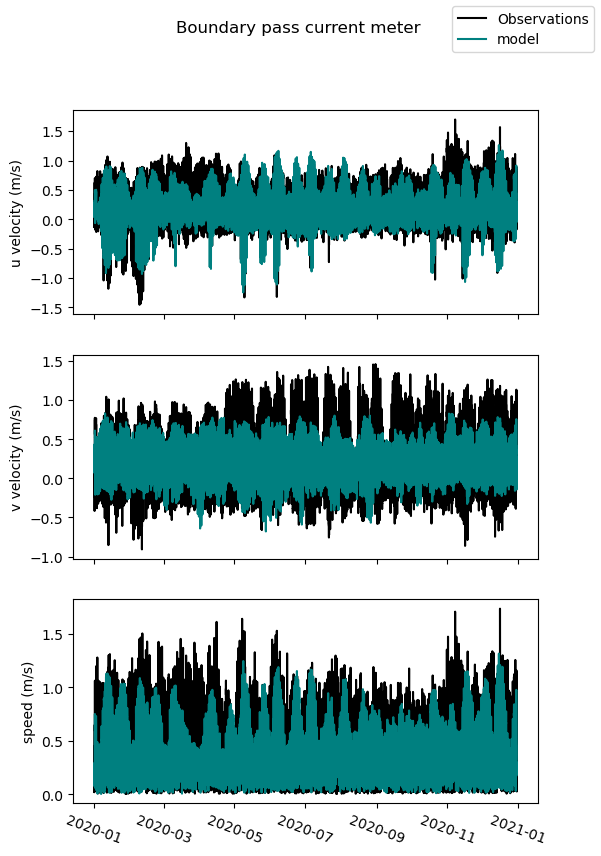

In [38]:
fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(6,9))
ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['current_velocity_east'],color='k',label='Observations')
ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['mod_east_vel'],color='teal',label='model')
ax.set_xticklabels([],rotation=-20)
ax.set_ylabel('u velocity (m/s)')

ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['current_velocity_north'],color='k')
ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['mod_north_vel'],color='teal')
ax2.set_xticklabels([],rotation=-20)
ax2.set_ylabel('v velocity (m/s)')

ax3.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['obs_speed'],color='k')
ax3.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['mod_speed'],color='teal')
plt.xticks(rotation=-20)
ax3.set_ylabel('speed (m/s)')
# plt.xticks(rotation=-20)

fig.legend()
fig.suptitle('Boundary pass current meter')

#### Time series for JdF

In [39]:
data_uvel_jdf['dtUTC']

data_uvel_jdf['dtime'] = pd.to_datetime(data_uvel_jdf['dtUTC'],format='mixed')
data_uvel_jdf_2021 = data_uvel_jdf[data_uvel_jdf['dtime'].dt.year == 2020]

data_vvel_jdf['dtime'] = pd.to_datetime(data_vvel_jdf['dtUTC'],format='mixed')
data_vvel_jdf_2021 = data_vvel_jdf[data_vvel_jdf['dtime'].dt.year == 2020]

Text(0.5, 0.98, 'JdF current meter')

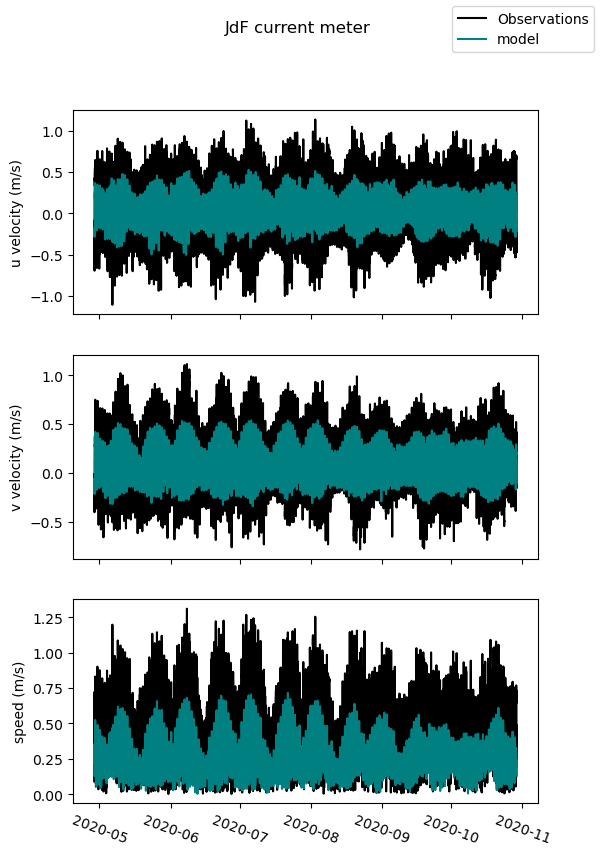

In [40]:
fig,[ax,ax2,ax3] = plt.subplots(3,1,figsize=(6,9))
ax.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['current_velocity_east'],color='k',label='Observations')
ax.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['mod_east_vel'],color='teal',label='model')
ax.set_xticklabels([],rotation=-20)
ax.set_ylabel('u velocity (m/s)')

ax2.plot(data_vvel_jdf_2021['dtime'],data_vvel_jdf_2021['current_velocity_north'],color='k')
ax2.plot(data_vvel_jdf_2021['dtime'],data_vvel_jdf_2021['mod_north_vel'],color='teal')
ax2.set_xticklabels([],rotation=-20)
ax2.set_ylabel('v velocity (m/s)')

ax3.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['obs_speed'],color='k')
ax3.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['mod_speed'],color='teal')
plt.xticks(rotation=-20)
ax3.set_ylabel('speed (m/s)')
# plt.xticks(rotation=-20)

fig.legend()
fig.suptitle('JdF current meter')

#### Time series for SoG

In [41]:
data_uvel_sog['dtime'] = pd.to_datetime(data_uvel_sog['dtUTC'],format='mixed')
data_uvel_sog_2021 = data_uvel_sog[data_uvel_sog['dtime'].dt.year == 2022]

data_vvel_sog['dtime'] = pd.to_datetime(data_vvel_sog['dtUTC'],format='mixed')
data_vvel_sog_2021 = data_vvel_sog[data_vvel_sog['dtime'].dt.year == 2022]

In [42]:
modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_sog21 = get_stats(data_uvel_sog_2021,'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_uvel_sog21.style.format(myformat).apply(highlight_max_min))

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_sog21 = get_stats(data_vvel_sog_2021,'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_vvel_sog21.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,45337,0.00637,0.0817,0.0814,0.92,0.229,0.0152,0.0382,0.0653,0.366


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,45338,-0.00772,0.0758,0.0754,0.851,-0.491,0.00255,0.0432,0.0843,-0.864


In [43]:
modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_jdf21 = get_stats(data_uvel_jdf_2021,'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_uvel_jdf21.style.format(myformat).apply(highlight_max_min))

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_jdf21 = get_stats(data_vvel_jdf_2021,'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_vvel_jdf21.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,26492,0.00147,0.228,0.228,0.82,0.538,0.0202,0.197,0.098,0.74


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.0195,0.177,0.176,0.849,0.476,0.0208,0.143,0.0892,0.674


In [44]:
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'

d_uvel_bp21 = get_stats(data_uvel_comb_2021,'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_uvel_bp21.style.format(myformat).apply(highlight_max_min))

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_bp21 = get_stats(data_vvel_comb_2021,'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')
display(d_vvel_bp21.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,0.0211,0.282,0.281,0.694,-0.0829,0.00474,0.0308,0.292,-0.0797


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,0.0241,0.284,0.283,0.647,0.507,0.108,0.154,0.201,0.483


(-1.5, 1.8)

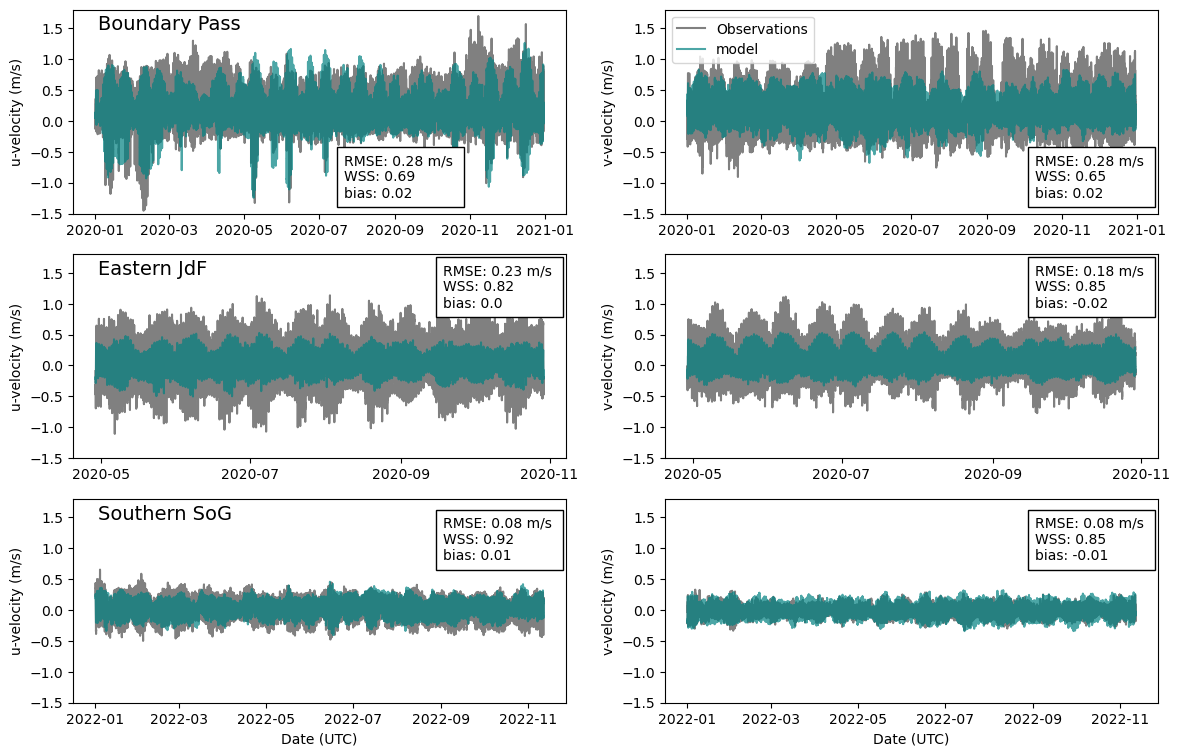

In [45]:
import matplotlib.dates as mdates

fig,[[ax,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(14,9))

ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['current_velocity_east'],color='grey',label='Observations')
ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['mod_east_vel'],color='teal',label='model',alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_ylabel('u-velocity (m/s)')

ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['current_velocity_north'],color='grey',label='Observations')
ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['mod_north_vel'],color='teal',label='model',alpha=0.7)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylabel('v-velocity (m/s)')
ax2.legend(loc=2)

ax3.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['current_velocity_east'],color='grey')
ax3.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['mod_east_vel'],color='teal',alpha=0.7)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.set_ylabel('u-velocity (m/s)')

ax4.plot(data_vvel_jdf_2021['dtime'],data_vvel_jdf_2021['current_velocity_north'],color='grey')
ax4.plot(data_vvel_jdf_2021['dtime'],data_vvel_jdf_2021['mod_north_vel'],color='teal',alpha=0.7)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.set_ylabel('v-velocity (m/s)')

ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['current_velocity_east'],color='grey')
ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['mod_east_vel'],color='teal',alpha=0.7)
ax5.set_ylabel('u-velocity (m/s)')
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax5.set_xlabel('Date (UTC)')

ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['current_velocity_north'],color='grey')
ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['mod_north_vel'],color='teal',alpha=0.7)
ax6.set_ylabel('v-velocity (m/s)')
ax6.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax6.set_xlabel('Date (UTC)')
# ax.legend(loc=4)

ax.text(0.05, 0.9, "Boundary Pass", transform=ax.transAxes, fontsize=14)
ax3.text(0.05, 0.9, "Eastern JdF", transform=ax3.transAxes, fontsize=14)
ax5.text(0.05, 0.9, "Southern SoG", transform=ax5.transAxes, fontsize=14)

met_bp_uvel = f"RMSE: {np.round(d_uvel_bp21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_bp21['swillmott'][0],2)} \nbias: {np.round(d_uvel_bp21['bias'][0],2)} "
ax.text(0.55, 0.08, met_bp_uvel, transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_bp_vvel = f"RMSE: {np.round(d_vvel_bp21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_bp21['swillmott'][0],2)} \nbias: {np.round(d_vvel_bp21['bias'][0],2)} "
ax2.text(0.75, 0.08, met_bp_vvel, transform=ax2.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_jdf_uvel = f"RMSE: {np.round(d_uvel_jdf21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_jdf21['swillmott'][0],2)} \nbias: {np.round(d_uvel_jdf21['bias'][0],2)} "
ax3.text(0.75, 0.74, met_jdf_uvel, transform=ax3.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_jdf_vvel = f"RMSE: {np.round(d_vvel_jdf21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_jdf21['swillmott'][0],2)} \nbias: {np.round(d_vvel_jdf21['bias'][0],2)} "
ax4.text(0.75, 0.74, met_jdf_vvel, transform=ax4.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_sog_uvel = f"RMSE: {np.round(d_uvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_uvel_sog21['bias'][0],2)} "
ax5.text(0.75, 0.7, met_sog_uvel, transform=ax5.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_sog_vvel = f"RMSE: {np.round(d_vvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_vvel_sog21['bias'][0],2)} "
ax6.text(0.75, 0.7, met_sog_vvel, transform=ax6.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

ax.set_ylim([-1.5,1.8])
ax2.set_ylim([-1.5,1.8])
ax3.set_ylim([-1.5,1.8])
ax4.set_ylim([-1.5,1.8])
ax5.set_ylim([-1.5,1.8])
ax6.set_ylim([-1.5,1.8])
# fig.subplots_adjust(hspace=0.32)

In [46]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/model_eval_currents.png',bbox_inches='tight')

In [47]:
# data_uvel_jdf['dtime'] = pd.to_datetime(data_uvel_jdf['dtUTC'],format='mixed')
# data_uvel_jdf_2021 = data_uvel_jdf[(data_uvel_jdf['dtime'].dt.year == 2020) | (data_uvel_jdf['dtime'].dt.year == 2018) | (data_uvel_jdf['dtime'].dt.year == 2019) ]

# data_vvel_jdf['dtime'] = pd.to_datetime(data_vvel_jdf['dtUTC'],format='mixed')
# data_vvel_jdf_2021 = data_vvel_jdf[(data_vvel_jdf['dtime'].dt.year == 2018) | (data_vvel_jdf['dtime'].dt.year == 2019) | (data_vvel_jdf['dtime'].dt.year == 2020)]


In [48]:
# fig,[[ax,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(14,9))

# ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['current_velocity_east'],color='grey',label='Observations')
# ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['mod_east_vel'],color='teal',label='model',alpha=0.7)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax.set_ylabel('u-velocity (m/s)')

# ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['current_velocity_north'],color='grey')
# ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['mod_north_vel'],color='teal',alpha=0.7)
# ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax2.set_ylabel('v-velocity (m/s)')

# ax3.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['current_velocity_east'],color='grey')
# ax3.plot(data_uvel_jdf_2021['dtime'],data_uvel_jdf_2021['mod_east_vel'],color='teal',alpha=0.7)
# ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax3.set_ylabel('u-velocity (m/s)')

# ax4.plot(data_vvel_jdf_2021['dtime'],data_vvel_jdf_2021['current_velocity_north'],color='grey')
# ax4.plot(data_vvel_jdf_2021['dtime'],data_vvel_jdf_2021['mod_north_vel'],color='teal',alpha=0.7)
# ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# ax4.set_ylabel('v-velocity (m/s)')

In [49]:
# plt.plot(data_uvel_jdf_2021['current_velocity_east'])

### Try to get better match for eJdF

Pressure @ mooring is around 105 dbar. File says depth is 111 m.

In [50]:
data_uvel_jdf

,Unnamed: 0,timeseries_id,dtUTC,current_velocity_east,current_velocity_north,current_speed_calculated,current_direction_calculated,heading,current_velocity_beam1_x_east,current_velocity_beam1_z_up,...,Lon,Z,j,i,mod_vozocrtx,k,mod_east_vel,obs_speed,mod_speed,dtime
0,0,scalar_1191250,2014-10-09 23:00:59.999,0.467765,0.128360,0.485057,74.655128,233.910260,0.412,0.036,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.485057,0.274611,2014-10-09 23:00:59.999
1,1,scalar_1191250,2014-10-09 23:10:59.999,0.368236,0.218355,0.428109,59.333122,249.810260,0.291,-0.018,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.428109,0.274611,2014-10-09 23:10:59.999
2,2,scalar_1191250,2014-10-09 23:20:59.999,0.405244,0.265794,0.484633,56.739676,256.710260,0.313,0.000,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.484633,0.274611,2014-10-09 23:20:59.999
3,3,scalar_1191250,2014-10-09 23:30:59.999,0.367421,0.233199,0.435178,57.597101,337.610260,0.286,0.045,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.435178,0.274611,2014-10-09 23:30:59.999
4,4,scalar_1191250,2014-10-09 23:40:59.998,0.256072,0.364246,0.445250,35.107981,326.610260,0.142,0.003,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.445250,0.274611,2014-10-09 23:40:59.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245152,1260,scalar_1210906,2021-12-30 22:57:53.253,-0.669626,-0.229640,0.707907,251.071202,320.971474,-0.582,0.013,...,-123.390000,111.0,278,180,-0.256393,27,-0.298080,0.707907,0.298213,2021-12-30 22:57:53.253
245153,1261,scalar_1210906,2021-12-30 23:12:53.252,-0.654742,-0.290995,0.716495,246.037574,317.471474,-0.551,0.023,...,-123.390000,111.0,278,180,-0.369980,27,-0.357108,0.716495,0.376384,2021-12-30 23:12:53.252
245154,1262,scalar_1210906,2021-12-30 23:27:53.252,-0.793445,-0.255977,0.833715,252.119528,317.871474,-0.694,-0.043,...,-123.390000,111.0,278,180,-0.369980,27,-0.357108,0.833715,0.376384,2021-12-30 23:27:53.252
245155,1263,scalar_1210906,2021-12-30 23:42:53.251,-0.600673,-0.364457,0.702593,238.752821,312.371474,-0.479,-0.012,...,-123.390000,111.0,278,180,-0.369980,27,-0.357108,0.702593,0.376384,2021-12-30 23:42:53.251


In [51]:
phys = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/29sep22/SalishSea_1h_20220929_20220929_grid_T.nc')
phys.deptht[27]

<xarray.DataArray 'deptht' ()>
array(121.866516, dtype=float32)
Coordinates:
    deptht   float32 121.9
Attributes:
    name:       deptht
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds

The current depth box its using is 27 which is 121 m. Try to use z = 26, which is 98 m. (Depth of mooring is at 105m)

In [52]:
def get_combined_v2(years, years_og, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False,gridN='None',straitn='_'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/gridV/ObsModel_202111_CIOOS_gridV_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_gridU_{year}0101_{year}1231.csv')
    for year in years_og:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}1231_k29.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}0331_k29.csv'
        file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0401_{year}1031_k29.csv'
        file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}1001_{year}1231_k29.csv'
        file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}0430_k29.csv'

        if os.path.exists(file_path1):
            pieces1.append(file_path1)

        if os.path.exists(file_path2):
            pieces1.append(file_path2)

        if os.path.exists(file_path3):
            pieces1.append(file_path3)

        if os.path.exists(file_path4):
            pieces1.append(file_path4)

        if os.path.exists(file_path5):
            pieces1.append(file_path5)

    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        
        if straitn == 'all':
            for ii in ['_','_jdf_']:
                file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}1231_v2.csv'

                if os.path.exists(file_path1):
                    pieces1.append(file_path1)
            
        else:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}1231_v2.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)
            

    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    # data_filter = temp1[temp1[modn].notna()]
    # print(data_filter)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

In [53]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 1.5
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_jdf_v2,d_uvel_jdf_v2 = get_combined_v2([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn,straitn='_jdf_')

display(d_uvel_jdf_v2.style.format(myformat).apply(highlight_max_min))

field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_jdf_v2,d_vvel_jdf_v2 = get_combined_v2([]#[2008,2009,2010,2012,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , [2020]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn,straitn='_jdf_')

d_vvel_jdf_v2.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,26492,0.0358,0.192,0.188,0.927,0.0165,0.0364,0.0363,0.187,0.0283


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.0473,0.24,0.236,0.738,0.472,-0.00723,0.148,0.16,0.558


In [54]:
data_uvel_jdf

,Unnamed: 0,timeseries_id,dtUTC,current_velocity_east,current_velocity_north,current_speed_calculated,current_direction_calculated,heading,current_velocity_beam1_x_east,current_velocity_beam1_z_up,...,Lon,Z,j,i,mod_vozocrtx,k,mod_east_vel,obs_speed,mod_speed,dtime
0,0,scalar_1191250,2014-10-09 23:00:59.999,0.467765,0.128360,0.485057,74.655128,233.910260,0.412,0.036,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.485057,0.274611,2014-10-09 23:00:59.999
1,1,scalar_1191250,2014-10-09 23:10:59.999,0.368236,0.218355,0.428109,59.333122,249.810260,0.291,-0.018,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.428109,0.274611,2014-10-09 23:10:59.999
2,2,scalar_1191250,2014-10-09 23:20:59.999,0.405244,0.265794,0.484633,56.739676,256.710260,0.313,0.000,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.484633,0.274611,2014-10-09 23:20:59.999
3,3,scalar_1191250,2014-10-09 23:30:59.999,0.367421,0.233199,0.435178,57.597101,337.610260,0.286,0.045,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.435178,0.274611,2014-10-09 23:30:59.999
4,4,scalar_1191250,2014-10-09 23:40:59.998,0.256072,0.364246,0.445250,35.107981,326.610260,0.142,0.003,...,-123.390944,112.0,278,180,0.143415,27,0.011898,0.445250,0.274611,2014-10-09 23:40:59.998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245152,1260,scalar_1210906,2021-12-30 22:57:53.253,-0.669626,-0.229640,0.707907,251.071202,320.971474,-0.582,0.013,...,-123.390000,111.0,278,180,-0.256393,27,-0.298080,0.707907,0.298213,2021-12-30 22:57:53.253
245153,1261,scalar_1210906,2021-12-30 23:12:53.252,-0.654742,-0.290995,0.716495,246.037574,317.471474,-0.551,0.023,...,-123.390000,111.0,278,180,-0.369980,27,-0.357108,0.716495,0.376384,2021-12-30 23:12:53.252
245154,1262,scalar_1210906,2021-12-30 23:27:53.252,-0.793445,-0.255977,0.833715,252.119528,317.871474,-0.694,-0.043,...,-123.390000,111.0,278,180,-0.369980,27,-0.357108,0.833715,0.376384,2021-12-30 23:27:53.252
245155,1263,scalar_1210906,2021-12-30 23:42:53.251,-0.600673,-0.364457,0.702593,238.752821,312.371474,-0.479,-0.012,...,-123.390000,111.0,278,180,-0.369980,27,-0.357108,0.702593,0.376384,2021-12-30 23:42:53.251


In [55]:
data_uvel_jdf_v2

,Unnamed: 0,timeseries_id,dtUTC,current_velocity_east,current_velocity_north,current_speed_calculated,current_direction_calculated,heading,current_velocity_beam1_x_east,current_velocity_beam1_z_up,...,roll,Sound_Speed,Temperature,Lat,Lon,Z,j,i,mod_vozocrtx,k
0,0,scalar_1206956,2020-04-28 16:32:46.995,-0.090930,-0.012517,0.091788,262.162349,182.334698,-0.084,1.149,...,2.0,1496.0,284.93,48.300783,-123.390617,98,278,180,-0.418471,26
1,1,scalar_1206956,2020-04-28 16:42:46.994,-0.403838,-0.008454,0.403927,268.800682,237.534697,-0.386,-0.025,...,0.2,1487.5,282.53,48.300783,-123.390617,98,278,180,-0.418471,26
2,2,scalar_1206956,2020-04-28 16:52:46.993,-0.407543,-0.032356,0.408825,265.460667,239.034697,-0.383,-0.021,...,0.2,1484.3,281.65,48.300783,-123.390617,98,278,180,-0.418471,26
3,3,scalar_1206956,2020-04-28 17:02:46.993,-0.382116,-0.114493,0.398900,253.320294,230.134697,-0.336,0.000,...,0.2,1483.0,281.29,48.300783,-123.390617,98,278,180,-0.600589,26
4,4,scalar_1206956,2020-04-28 17:12:46.992,-0.351481,-0.134679,0.376400,249.034356,233.934697,-0.301,-0.020,...,0.0,1482.4,281.13,48.300783,-123.390617,98,278,180,-0.600589,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26487,26487,scalar_1206956,2020-10-29 15:02:31.016,-0.369890,-0.152582,0.400125,247.583573,241.785566,-0.314,0.008,...,0.1,1481.0,280.79,48.300783,-123.390617,98,278,180,-0.203242,26
26488,26488,scalar_1206956,2020-10-29 15:12:31.015,-0.292162,-0.135193,0.321925,245.168445,243.885567,-0.244,-0.026,...,0.0,1481.1,280.81,48.300783,-123.390617,98,278,180,-0.203242,26
26489,26489,scalar_1206956,2020-10-29 15:22:31.014,-0.224490,-0.091030,0.242244,247.927606,246.985567,-0.191,0.007,...,0.0,1481.1,280.81,48.300783,-123.390617,98,278,180,-0.203242,26
26490,26490,scalar_1206956,2020-10-29 15:32:31.014,-0.310505,-0.064472,0.317128,258.270076,249.985567,-0.281,0.002,...,0.1,1481.1,280.81,48.300783,-123.390617,98,278,180,-0.203242,26


In [56]:
data_uvel_jdf_v2['mod_east_vel'] = data_uvel_jdf_v2['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_jdf_v2['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_jdf_v2['mod_north_vel'] = data_uvel_jdf_v2['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_jdf_v2['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_jdf_v2 = get_stats(filter_bad_data(data_uvel_jdf_v2),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

data_vvel_jdf_v2 = data_vvel_jdf_v2[data_vvel_jdf_v2['mod_north_vel'].notna()]
d_vvel_jdf_v2 = get_stats(filter_bad_data(data_vvel_jdf_v2),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_jdf_v2.style.format(myformat).apply(highlight_max_min))
display(d_vvel_jdf_v2.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,26492,0.00872,0.153,0.153,0.949,0.114,0.0127,0.0425,0.139,0.197


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.0178,0.139,0.138,0.932,0.184,-0.00221,0.0575,0.116,0.303


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,26492,-0.0178,0.139,0.138,0.932,0.184,-0.00221,0.0575,0.116,0.303


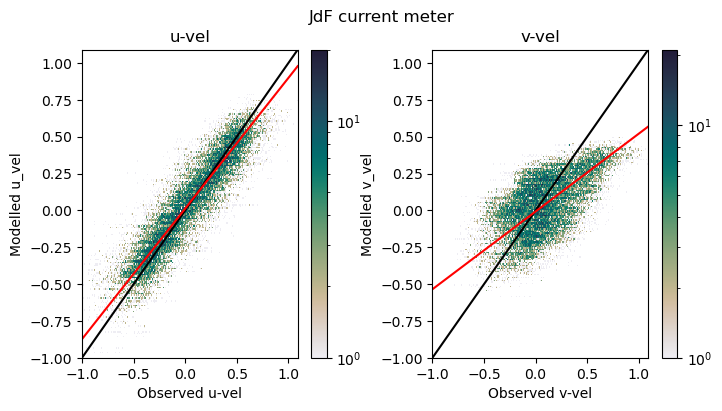

In [57]:
vmax = 1.1
vmin = -1

fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

counts, xedges, yedges, color = ax.hist2d( data_uvel_jdf_v2['current_velocity_east'],data_uvel_jdf_v2['mod_east_vel'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax.set_xlabel(f'Observed u-vel')
ax.set_ylabel(f'Modelled u_vel')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_uvel_jdf_v2,'current_velocity_east','mod_east_vel')
line = a1+np.arange(vmin, vmax, 0.01)*b1
# slope,intercept = np.polyfit(data_uvel['i_vel'],data_uvel['mod_vozocrtx'],1)
# line = slope*np.arange(vmin,vmax,0.01)+intercept
ax.plot(np.arange(vmin,vmax,0.01),line,'r')
ax.set_title('u-vel')

counts, xedges, yedges, color = ax2.hist2d( data_vvel_jdf_v2['current_velocity_north'],data_vvel_jdf_v2['mod_vomecrty'],
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),cmap=cmap);
ax2.set_xlabel(f'Observed v-vel')
ax2.set_ylabel(f'Modelled v_vel')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(vmin,vmax,0.01),np.arange(vmin,vmax,0.01),color='k')
a1,b1,stm,nstm = wolfram_perp(data_vvel_jdf_v2,'current_velocity_north','mod_vomecrty')
line = a1+np.arange(vmin, vmax, 0.01)*b1
ax2.plot(np.arange(vmin,vmax,0.01),line,'r')
ax2.set_title('v-vel')
fig.suptitle('JdF current meter')
fig.subplots_adjust(wspace=0.3)

display(d_vvel_jdf_v2.style.format(myformat).apply(highlight_max_min))
# d_uvel_jdf_v2.style.format(myformat).apply(highlight_max_min)

In [58]:
data_uvel_jdf_v2['dtime'] = pd.to_datetime(data_uvel_jdf_v2['dtUTC'],format='mixed')
data_vvel_jdf_v2['dtime'] = pd.to_datetime(data_vvel_jdf_v2['dtUTC'],format='mixed')

(-1.5, 1.8)

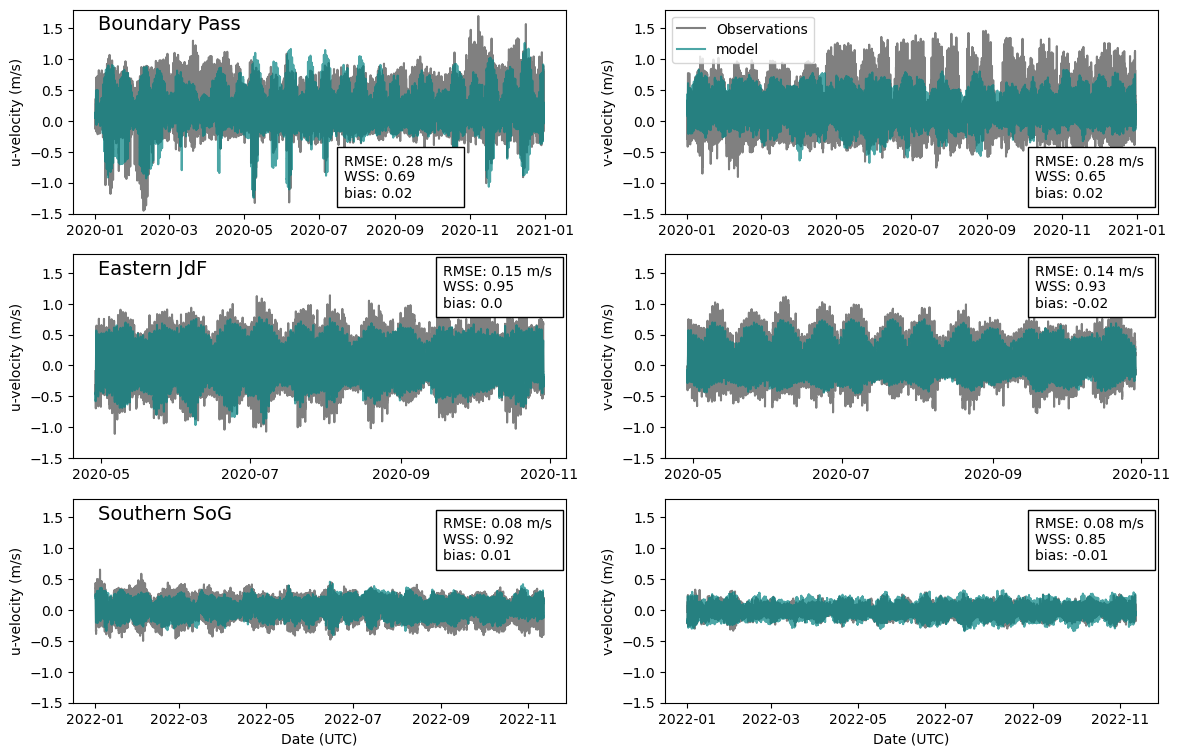

In [59]:
import matplotlib.dates as mdates

fig,[[ax,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(14,9))

ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['current_velocity_east'],color='grey',label='Observations')
ax.plot(data_uvel_comb_2021['dtime'],data_uvel_comb_2021['mod_east_vel'],color='teal',label='model',alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_ylabel('u-velocity (m/s)')

ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['current_velocity_north'],color='grey',label='Observations')
ax2.plot(data_vvel_comb_2021['dtime'],data_vvel_comb_2021['mod_north_vel'],color='teal',label='model',alpha=0.7)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylabel('v-velocity (m/s)')
ax2.legend(loc=2)

ax3.plot(data_uvel_jdf_v2['dtime'],data_uvel_jdf_v2['current_velocity_east'],color='grey')
ax3.plot(data_uvel_jdf_v2['dtime'],data_uvel_jdf_v2['mod_east_vel'],color='teal',alpha=0.7)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.set_ylabel('u-velocity (m/s)')

ax4.plot(data_vvel_jdf_v2['dtime'],data_vvel_jdf_v2['current_velocity_north'],color='grey')
ax4.plot(data_vvel_jdf_v2['dtime'],data_vvel_jdf_v2['mod_north_vel'],color='teal',alpha=0.7)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.set_ylabel('v-velocity (m/s)')

ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['current_velocity_east'],color='grey')
ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['mod_east_vel'],color='teal',alpha=0.7)
ax5.set_ylabel('u-velocity (m/s)')
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax5.set_xlabel('Date (UTC)')

ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['current_velocity_north'],color='grey')
ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['mod_north_vel'],color='teal',alpha=0.7)
ax6.set_ylabel('v-velocity (m/s)')
ax6.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax6.set_xlabel('Date (UTC)')
# ax.legend(loc=4)

ax.text(0.05, 0.9, "Boundary Pass", transform=ax.transAxes, fontsize=14)
ax3.text(0.05, 0.9, "Eastern JdF", transform=ax3.transAxes, fontsize=14)
ax5.text(0.05, 0.9, "Southern SoG", transform=ax5.transAxes, fontsize=14)

met_bp_uvel = f"RMSE: {np.round(d_uvel_bp21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_bp21['swillmott'][0],2)} \nbias: {np.round(d_uvel_bp21['bias'][0],2)} "
ax.text(0.55, 0.08, met_bp_uvel, transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_bp_vvel = f"RMSE: {np.round(d_vvel_bp21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_bp21['swillmott'][0],2)} \nbias: {np.round(d_vvel_bp21['bias'][0],2)} "
ax2.text(0.75, 0.08, met_bp_vvel, transform=ax2.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_jdf_uvel = f"RMSE: {np.round(d_uvel_jdf_v2['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_jdf_v2['swillmott'][0],2)} \nbias: {np.round(d_uvel_jdf21['bias'][0],2)} "
ax3.text(0.75, 0.74, met_jdf_uvel, transform=ax3.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_jdf_vvel = f"RMSE: {np.round(d_vvel_jdf_v2['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_jdf_v2['swillmott'][0],2)} \nbias: {np.round(d_vvel_jdf21['bias'][0],2)} "
ax4.text(0.75, 0.74, met_jdf_vvel, transform=ax4.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_sog_uvel = f"RMSE: {np.round(d_uvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_uvel_sog21['bias'][0],2)} "
ax5.text(0.75, 0.7, met_sog_uvel, transform=ax5.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_sog_vvel = f"RMSE: {np.round(d_vvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_vvel_sog21['bias'][0],2)} "
ax6.text(0.75, 0.7, met_sog_vvel, transform=ax6.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

ax.set_ylim([-1.5,1.8])
ax2.set_ylim([-1.5,1.8])
ax3.set_ylim([-1.5,1.8])
ax4.set_ylim([-1.5,1.8])
ax5.set_ylim([-1.5,1.8])
ax6.set_ylim([-1.5,1.8])
# fig.subplots_adjust(hspace=0.32)

### Try to get better match for boundary pass

In [60]:
data_uvel.keys()

Index(['Unnamed: 0', 'timeseries_id', 'dtUTC', 'current_velocity_beam1_z_up',
       'current_velocity_beam2_y_north', 'magnetic_heading', 'pitch',
       'Pressure', 'roll', 'Sound_Speed', 'Temperature',
       'current_velocity_east', 'current_velocity_north',
       'current_speed_calculated', 'current_direction_calculated', 'heading',
       'current_velocity_beam1_x_east', 'Lat', 'Lon', 'Z', 'j', 'i',
       'mod_vozocrtx', 'k', 'mod_east_vel', 'obs_speed', 'mod_speed'],
      dtype='object')

In [61]:
phys2 =  xr.open_dataset('/results2/SalishSea/nowcast-green.202111/29sep22/SalishSea_1h_20220929_20220929_grid_U.nc')
phys3 =  xr.open_dataset('/results2/SalishSea/nowcast-green.202111/29sep22/SalishSea_1h_20220929_20220929_grid_V.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
vmask = 1 - mesh.vmask[0]
umask = 1 - mesh.umask[0]
phys2.vozocrtx[0,29,343,288].values

array(0.38251528)

In [62]:
phys3.vomecrty[0,29,343,288].values

array(0.01796006)

In [63]:
phys.deptht[29]

<xarray.DataArray 'deptht' ()>
array(173.11449, dtype=float32)
Coordinates:
    deptht   float32 173.1
Attributes:
    name:       deptht
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds

### Try to find different point

In [64]:
phys3.vomecrty[0,29,343,288].values

array(0.01796006)

In [65]:
phys2.vozocrtx[0,29,343,288].values

array(0.38251528)

In [66]:
phys3

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, nvertex: 4, depthv: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * depthv                (depthv) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2022-09-29T00:30:00 ....
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    depthv_bounds         (depthv, axis_nbounds) float32 ...
    vomecrty              (time_counter, depthv, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
Attributes:
    name:         SalishSea_1h_20220926_20220930
    description:  V velocity
    title:        V velocity
    Conventions:  CF-1.6
    timeStamp:    2022-Dec-26 09:39:59 GMT
    uuid:         05e94f74-9e46-45de-950e-591efbf9ece8

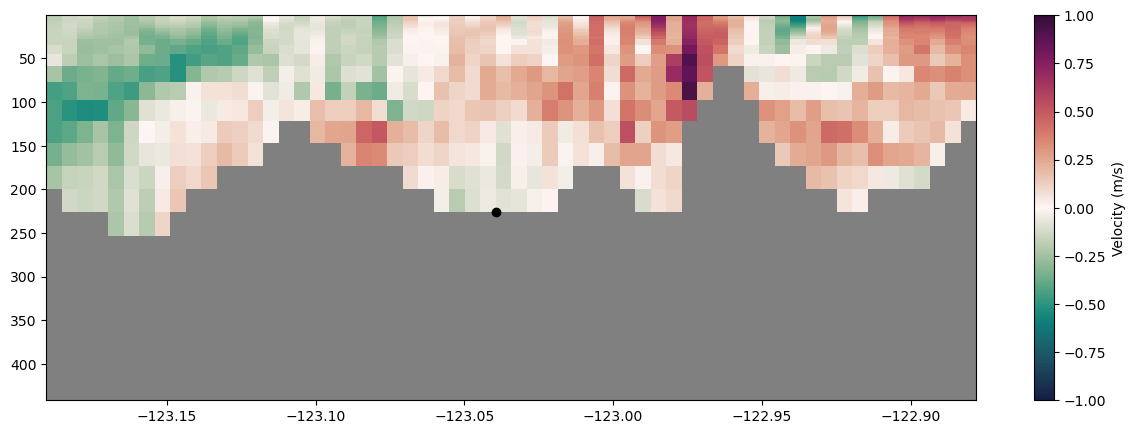

In [67]:
vvel = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/29sep22/SalishSea_1h_20220929_20220929_grid_V.nc')
uvel = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/29sep22/SalishSea_1h_20220929_20220929_grid_U.nc')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cmap = cm.curl
cmap.set_bad('grey')
northvel = np.ma.masked_array(vvel.vomecrty[1, :, 343, 260:320], mask=vmask[:, 343, 260:320])
colours = ax.pcolormesh(vvel.nav_lon[343, 260:320+1], vvel.depthv, northvel[:39], cmap=cmap, vmax=1.0, vmin=-1.0)
# ax.set_ylim(0, 150)
ax.invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Velocity (m/s)');
ax.scatter(-123.03953,226,color='k')

In [68]:
uvel.nav_lon[344,289].values

array(-123.03852, dtype=float32)

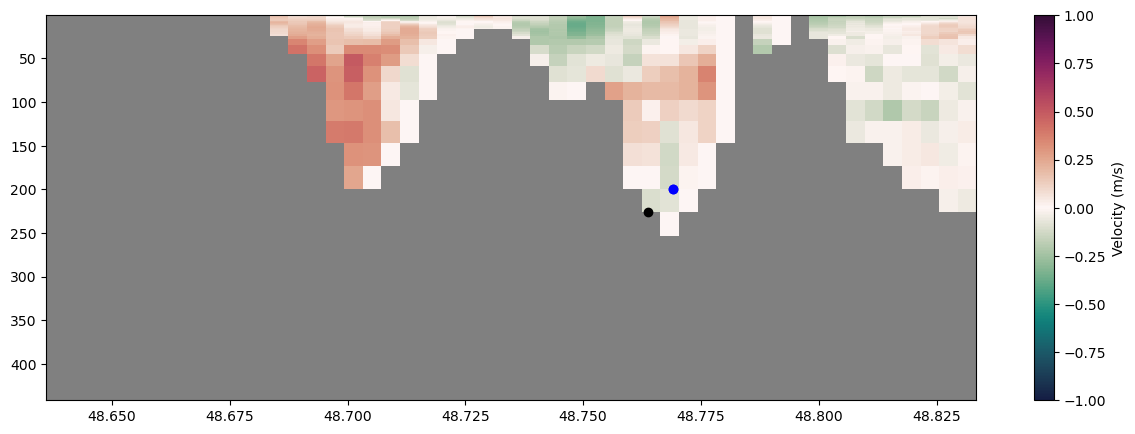

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cmap = cm.curl
cmap.set_bad('grey')
northvel = np.ma.masked_array(vvel.vomecrty[1, :, 310:360, 289], mask=umask[:, 310:360, 289])
colours = ax.pcolormesh(uvel.nav_lat[310:360+1,289], uvel.depthu, northvel[:39], cmap=cmap, vmax=1.0, vmin=-1.0)
# ax.set_ylim(0, 150)
ax.invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Velocity (m/s)');
ax.scatter(48.7638,226,color='k')
ax.scatter(48.769,199,color='b')
ax.scatter(48.769,199,color='b')
# ax.scatter(343,226,color='k')
# ax.scatter(344,199,color='b')
# ax.scatter(343,199,color='purple')
# ax.scatter(48.769,199,color='b')

In [70]:
uvel

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, nvertex: 4, depthu: 40,
                           axis_nbounds: 2, time_counter: 24)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * depthu                (depthu) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2022-09-29T00:30:00 ....
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    depthu_bounds         (depthu, axis_nbounds) float32 ...
    vozocrtx              (time_counter, depthu, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
Attributes:
    name:         SalishSea_1h_20220926_20220930
    description:  U velocity
    title:        U velocity
    Conventions:  CF-1.6
    timeStamp:    2022-Dec-26 09:39:58 GMT
    uuid:         9eb700e6-218e-40f8-a606-0b95c50c9431

In [71]:
phys2.vozocrtx[0,31,343,288].values

array(0.14843245)

In [72]:
phys.nav_lat[344,289].values

array(48.769398, dtype=float32)

In [73]:
phys.deptht

<xarray.DataArray 'deptht' (deptht: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    name:       deptht
    long_name:  Vertical T levels
    units:      m
    axis:       Z
    positive:   down
    bounds:     deptht_bounds

Try with k=29 

In [74]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_k29,d_uvel_k29 = get_combined_v2([]
                                          , [2020]
                                          , []#
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

display(d_uvel_k29.style.format(myformat).apply(highlight_max_min))

# plt.scatter(data_uvel_2012['mod_vozocrtx'],data_uvel_OG['mod_vozocrtx'],s=1)
# plt.plot(np.arange(-1,1,0.1),np.arange(-1,1,0.1),'k')

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,0.00916,0.398,0.398,0.624,-1.62,-0.312,0.439,0.65,-1.57


In [75]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_k29,d_vvel_k29 = get_combined_v2([]#[2008,2009,2010,2012,2021,2022]
                                          , [2020]#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel_k29.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,-0.0926,0.268,0.252,0.719,0.385,-0.0287,0.148,0.193,0.436


In [76]:
data_uvel_k29['mod_east_vel'] = data_uvel_k29['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_k29['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_k29['mod_north_vel'] = data_uvel_k29['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_k29['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_k29 = get_stats(filter_bad_data(data_uvel_k29),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_k29 = get_stats(filter_bad_data(data_vvel_k29),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_k29.style.format(myformat).apply(highlight_max_min))
display(d_vvel_k29.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,-0.0523,0.329,0.325,0.646,-0.575,-0.166,0.164,0.412,-0.49


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,-0.00166,0.277,0.277,0.802,-0.314,-0.0538,0.0943,0.312,-0.439


In [77]:
data_uvel_k29['dtime'] = pd.to_datetime(data_uvel_k29['dtUTC'],format='mixed')
data_vvel_k29['dtime'] = pd.to_datetime(data_vvel_k29['dtUTC'],format='mixed')

(-1.5, 1.8)

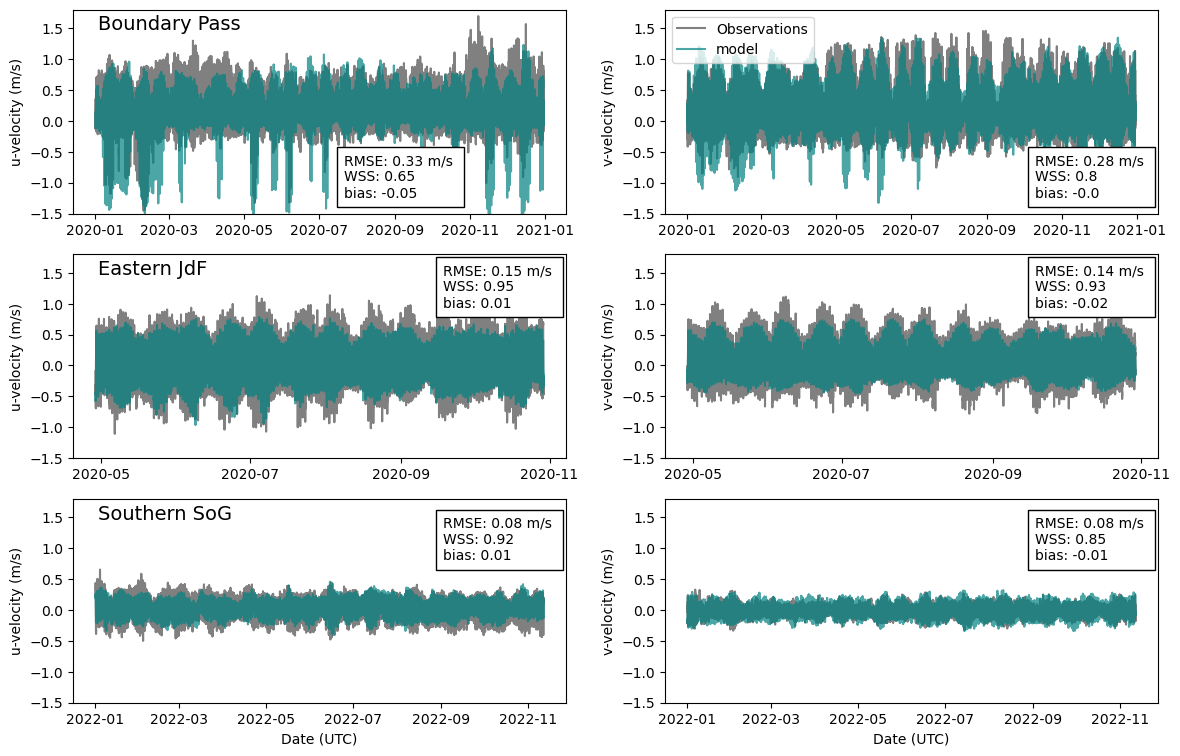

In [78]:
import matplotlib.dates as mdates

fig,[[ax,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(14,9))

ax.plot(data_uvel_k29['dtime'],data_uvel_k29['current_velocity_east'],color='grey',label='Observations')
ax.plot(data_uvel_k29['dtime'],data_uvel_k29['mod_east_vel'],color='teal',label='model',alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_ylabel('u-velocity (m/s)')

ax2.plot(data_vvel_k29['dtime'],data_vvel_k29['current_velocity_north'],color='grey',label='Observations')
ax2.plot(data_vvel_k29['dtime'],data_vvel_k29['mod_north_vel'],color='teal',label='model',alpha=0.7)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylabel('v-velocity (m/s)')
ax2.legend(loc=2)

ax3.plot(data_uvel_jdf_v2['dtime'],data_uvel_jdf_v2['current_velocity_east'],color='grey')
ax3.plot(data_uvel_jdf_v2['dtime'],data_uvel_jdf_v2['mod_east_vel'],color='teal',alpha=0.7)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.set_ylabel('u-velocity (m/s)')

ax4.plot(data_vvel_jdf_v2['dtime'],data_vvel_jdf_v2['current_velocity_north'],color='grey')
ax4.plot(data_vvel_jdf_v2['dtime'],data_vvel_jdf_v2['mod_north_vel'],color='teal',alpha=0.7)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.set_ylabel('v-velocity (m/s)')

ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['current_velocity_east'],color='grey')
ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['mod_east_vel'],color='teal',alpha=0.7)
ax5.set_ylabel('u-velocity (m/s)')
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax5.set_xlabel('Date (UTC)')

ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['current_velocity_north'],color='grey')
ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['mod_north_vel'],color='teal',alpha=0.7)
ax6.set_ylabel('v-velocity (m/s)')
ax6.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax6.set_xlabel('Date (UTC)')
# ax.legend(loc=4)

ax.text(0.05, 0.9, "Boundary Pass", transform=ax.transAxes, fontsize=14)
ax3.text(0.05, 0.9, "Eastern JdF", transform=ax3.transAxes, fontsize=14)
ax5.text(0.05, 0.9, "Southern SoG", transform=ax5.transAxes, fontsize=14)

met_bp_uvel = f"RMSE: {np.round(d_uvel_k29['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_k29['swillmott'][0],2)} \nbias: {np.round(d_uvel_k29['bias'][0],2)} "
ax.text(0.55, 0.08, met_bp_uvel, transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_bp_vvel = f"RMSE: {np.round(d_vvel_k29['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_k29['swillmott'][0],2)} \nbias: {np.round(d_vvel_k29['bias'][0],2)} "
ax2.text(0.75, 0.08, met_bp_vvel, transform=ax2.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_jdf_uvel = f"RMSE: {np.round(d_uvel_jdf_v2['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_jdf_v2['swillmott'][0],2)} \nbias: {np.round(d_uvel_jdf_v2['bias'][0],2)} "
ax3.text(0.75, 0.74, met_jdf_uvel, transform=ax3.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_jdf_vvel = f"RMSE: {np.round(d_vvel_jdf_v2['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_jdf_v2['swillmott'][0],2)} \nbias: {np.round(d_vvel_jdf_v2['bias'][0],2)} "
ax4.text(0.75, 0.74, met_jdf_vvel, transform=ax4.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_sog_uvel = f"RMSE: {np.round(d_uvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_uvel_sog21['bias'][0],2)} "
ax5.text(0.75, 0.7, met_sog_uvel, transform=ax5.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_sog_vvel = f"RMSE: {np.round(d_vvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_vvel_sog21['bias'][0],2)} "
ax6.text(0.75, 0.7, met_sog_vvel, transform=ax6.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

ax.set_ylim([-1.5,1.8])
ax2.set_ylim([-1.5,1.8])
ax3.set_ylim([-1.5,1.8])
ax4.set_ylim([-1.5,1.8])
ax5.set_ylim([-1.5,1.8])
ax6.set_ylim([-1.5,1.8])
# fig.subplots_adjust(hspace=0.32)

Now try k=29 for v-vel and k=30 for u-vel

In [79]:
data_uvel['dtime'] = pd.to_datetime(data_uvel['dtUTC'],format='mixed')
data_uvel_2020 = data_uvel[data_uvel['dtime'].dt.year == 2020]

In [80]:
data_uvel_k2930 = data_uvel_k29.copy()
data_vvel_k2930 = data_vvel_k29.copy()

data_uvel_k2930['mod_east_vel'] = data_uvel_2020['mod_vozocrtx'].values*np.cos(np.deg2rad(29)) - data_vvel_k29['mod_vomecrty'].values*np.sin(np.deg2rad(29))
data_vvel_k2930['mod_north_vel'] = data_uvel_2020['mod_vozocrtx'].values*np.sin(np.deg2rad(29)) + data_vvel_k29['mod_vomecrty'].values*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_k2930 = get_stats(filter_bad_data(data_uvel_k2930),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_k2930 = get_stats(filter_bad_data(data_vvel_k2930),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_k2930.style.format(myformat).apply(highlight_max_min))
display(d_vvel_k2930.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,52403,-0.0238,0.287,0.286,0.687,-0.12,-0.0475,0.0402,0.302,-0.113


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,52403,0.0142,0.261,0.26,0.816,-0.207,-0.0202,0.0637,0.283,-0.292


(-1.5, 1.8)

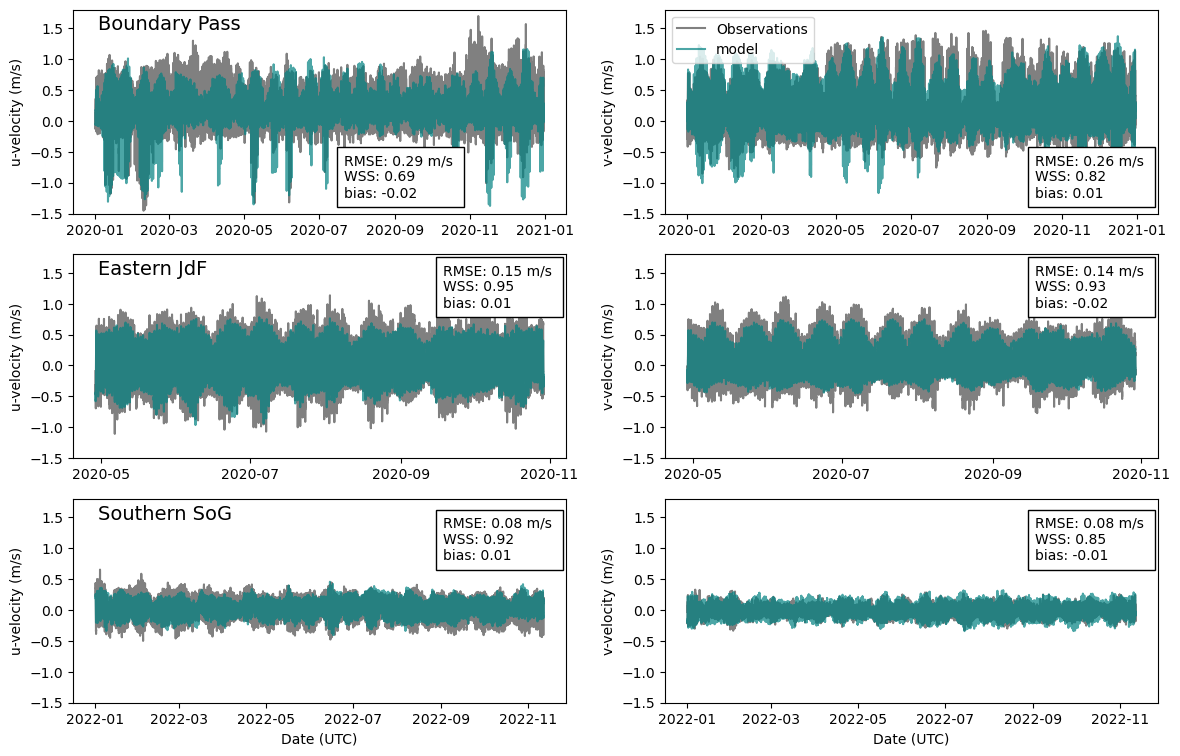

In [81]:
import matplotlib.dates as mdates

fig,[[ax,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(14,9))

ax.plot(data_uvel_k2930['dtime'],data_uvel_k2930['current_velocity_east'],color='grey',label='Observations')
ax.plot(data_uvel_k2930['dtime'],data_uvel_k2930['mod_east_vel'],color='teal',label='model',alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.set_ylabel('u-velocity (m/s)')

ax2.plot(data_vvel_k2930['dtime'],data_vvel_k2930['current_velocity_north'],color='grey',label='Observations')
ax2.plot(data_vvel_k2930['dtime'],data_vvel_k2930['mod_north_vel'],color='teal',label='model',alpha=0.7)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.set_ylabel('v-velocity (m/s)')
ax2.legend(loc=2)

ax3.plot(data_uvel_jdf_v2['dtime'],data_uvel_jdf_v2['current_velocity_east'],color='grey')
ax3.plot(data_uvel_jdf_v2['dtime'],data_uvel_jdf_v2['mod_east_vel'],color='teal',alpha=0.7)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax3.set_ylabel('u-velocity (m/s)')

ax4.plot(data_vvel_jdf_v2['dtime'],data_vvel_jdf_v2['current_velocity_north'],color='grey')
ax4.plot(data_vvel_jdf_v2['dtime'],data_vvel_jdf_v2['mod_north_vel'],color='teal',alpha=0.7)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax4.set_ylabel('v-velocity (m/s)')

ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['current_velocity_east'],color='grey')
ax5.plot(data_uvel_sog_2021['dtime'],data_uvel_sog_2021['mod_east_vel'],color='teal',alpha=0.7)
ax5.set_ylabel('u-velocity (m/s)')
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax5.set_xlabel('Date (UTC)')

ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['current_velocity_north'],color='grey')
ax6.plot(data_vvel_sog_2021['dtime'],data_vvel_sog_2021['mod_north_vel'],color='teal',alpha=0.7)
ax6.set_ylabel('v-velocity (m/s)')
ax6.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax6.set_xlabel('Date (UTC)')
# ax.legend(loc=4)

ax.text(0.05, 0.9, "Boundary Pass", transform=ax.transAxes, fontsize=14)
ax3.text(0.05, 0.9, "Eastern JdF", transform=ax3.transAxes, fontsize=14)
ax5.text(0.05, 0.9, "Southern SoG", transform=ax5.transAxes, fontsize=14)

met_bp_uvel = f"RMSE: {np.round(d_uvel_k2930['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_k2930['swillmott'][0],2)} \nbias: {np.round(d_uvel_k2930['bias'][0],2)} "
ax.text(0.55, 0.08, met_bp_uvel, transform=ax.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_bp_vvel = f"RMSE: {np.round(d_vvel_k2930['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_k2930['swillmott'][0],2)} \nbias: {np.round(d_vvel_k2930['bias'][0],2)} "
ax2.text(0.75, 0.08, met_bp_vvel, transform=ax2.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_jdf_uvel = f"RMSE: {np.round(d_uvel_jdf_v2['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_jdf_v2['swillmott'][0],2)} \nbias: {np.round(d_uvel_jdf_v2['bias'][0],2)} "
ax3.text(0.75, 0.74, met_jdf_uvel, transform=ax3.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_jdf_vvel = f"RMSE: {np.round(d_vvel_jdf_v2['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_jdf_v2['swillmott'][0],2)} \nbias: {np.round(d_vvel_jdf_v2['bias'][0],2)} "
ax4.text(0.75, 0.74, met_jdf_vvel, transform=ax4.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

met_sog_uvel = f"RMSE: {np.round(d_uvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_uvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_uvel_sog21['bias'][0],2)} "
ax5.text(0.75, 0.7, met_sog_uvel, transform=ax5.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))
met_sog_vvel = f"RMSE: {np.round(d_vvel_sog21['rmse'][0],2)} m/s \nWSS: {np.round(d_vvel_sog21['swillmott'][0],2)} \nbias: {np.round(d_vvel_sog21['bias'][0],2)} "
ax6.text(0.75, 0.7, met_sog_vvel, transform=ax6.transAxes, fontsize=10,bbox=dict(facecolor='w', edgecolor='black', pad=5))

ax.set_ylim([-1.5,1.8])
ax2.set_ylim([-1.5,1.8])
ax3.set_ylim([-1.5,1.8])
ax4.set_ylim([-1.5,1.8])
ax5.set_ylim([-1.5,1.8])
ax6.set_ylim([-1.5,1.8])
# fig.subplots_adjust(hspace=0.32)

Try at j=344 and k = 29

In [82]:
def get_combined_v3(years, years_og, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False,gridN='None',straitn='_'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/gridV/ObsModel_202111_CIOOS_gridV_{year}0101_{year}1231.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_gridU_{year}0101_{year}1231.csv')
    for year in years_og:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}1231_k29j344.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}0331_k29j344.csv'
        file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0401_{year}1031_k29j344.csv'
        file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}1001_{year}1231_k29j344.csv'
        file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_{gridN}_{year}0101_{year}0430_k29j344.csv'

        if os.path.exists(file_path1):
            pieces1.append(file_path1)

        if os.path.exists(file_path2):
            pieces1.append(file_path2)

        if os.path.exists(file_path3):
            pieces1.append(file_path3)

        if os.path.exists(file_path4):
            pieces1.append(file_path4)

        if os.path.exists(file_path5):
            pieces1.append(file_path5)

    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        
        if straitn == 'all':
            for ii in ['_','_jdf_']:
                file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{ii}{gridN}_{year}0101_{year}1231_v2.csv'

                if os.path.exists(file_path1):
                    pieces1.append(file_path1)
            
        else:
            file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc{straitn}{gridN}_{year}0101_{year}1231_v2.csv'

            if os.path.exists(file_path1):
                pieces1.append(file_path1)
            

    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    # data_filter = temp1[temp1[modn].notna()]
    # print(data_filter)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

In [83]:
field = 'u-vel'
obsn = 'current_velocity_east'
modn = 'mod_vozocrtx'
gridn = 'gridU'
vmax = 0.6
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_uvel_k29j344,d_uvel_k29j344 = get_combined_v3([]
                                          , [2020]
                                          , []#
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

display(d_uvel_k29j344.style.format(myformat).apply(highlight_max_min))

# plt.scatter(data_uvel_2012['mod_vozocrtx'],data_uvel_OG['mod_vozocrtx'],s=1)
# plt.plot(np.arange(-1,1,0.1),np.arange(-1,1,0.1),'k')

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,27202,0.0959,0.427,0.416,0.519,-3.58,-0.517,0.827,1.01,-2.37


In [84]:
field = 'v-vel'
obsn = 'current_velocity_north'
modn = 'mod_vomecrty'
gridn = 'gridV'
vmax = 1
vmin = -0.6
dbin = 0.01
scale = 24

idepth = 0
jdepth = 39

data_vvel_k29j344,d_vvel_k29j344 = get_combined_v3([]#[2008,2009,2010,2012,2021,2022]
                                          , [2020]#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths',gridN=gridn)

d_vvel_k29j344.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,27202,-0.124,0.297,0.27,0.591,0.716,0.00424,0.26,0.121,0.797


In [85]:
data_uvel_k29j344['mod_east_vel'] = data_uvel_k29j344['mod_vozocrtx']*np.cos(np.deg2rad(29)) - data_vvel_k29j344['mod_vomecrty']*np.sin(np.deg2rad(29))
data_vvel_k29j344['mod_north_vel'] = data_uvel_k29j344['mod_vozocrtx']*np.sin(np.deg2rad(29)) + data_vvel_k29j344['mod_vomecrty']*np.cos(np.deg2rad(29))

modn = 'mod_east_vel'
obsn = 'current_velocity_east'

d_uvel_k29j344 = get_stats(filter_bad_data(data_uvel_k29j344),'u-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

modn = 'mod_north_vel'
obsn = 'current_velocity_north'

d_vvel_k29j344 = get_stats(filter_bad_data(data_vvel_k29j344),'v-vel' , idepth, jdepth, 'all_depths', reverse=False,string='')

display(d_uvel_k29j344.style.format(myformat).apply(highlight_max_min))
display(d_vvel_k29j344.style.format(myformat).apply(highlight_max_min))

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
u-vel,27202,0.0357,0.341,0.339,0.562,-1.8,-0.272,0.414,0.629,-1.01


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
v-vel,27202,-0.00126,0.269,0.269,0.788,0.0788,0.0128,0.0252,0.258,0.098


Willmott not as good as before. 

#### Conclusion: use the eval with u-vel @ k=30 and v-vel @ 29 for j=343